In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.mixture import GaussianMixture
import seaborn as sns
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import scipy.signal as signal
from sklearn.impute import KNNImputer
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import OneHotEncoder
from scipy.fftpack import fft
from scipy.signal import periodogram,find_peaks
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.stattools import durbin_watson
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import grangercausalitytests

from sktime.datatypes._panel._convert import from_3d_numpy_to_nested
from sklearn.metrics import classification_report,confusion_matrix, ConfusionMatrixDisplay
from sktime.classification.interval_based import TimeSeriesForestClassifier
from sktime.classification.compose import ColumnEnsembleClassifier
from sktime.classification.kernel_based import RocketClassifier
from sktime.classification.hybrid import HIVECOTEV2
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import TimeSeriesSplit, cross_val_predict
import shap
from sklearn.neighbors import NearestNeighbors

from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR


from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
df = pd.read_csv("BEIJING.csv")

In [3]:
df

No  year  month  day  hour  pm2.5  DEWP  TEMP    PRES cbwd     Iws  \
0          1  2010      1    1     0    NaN   -21 -11.0  1021.0   NW    1.79   
1          2  2010      1    1     1    NaN   -21 -12.0  1020.0   NW    4.92   
2          3  2010      1    1     2    NaN   -21 -11.0  1019.0   NW    6.71   
3          4  2010      1    1     3    NaN   -21 -14.0  1019.0   NW    9.84   
4          5  2010      1    1     4    NaN   -20 -12.0  1018.0   NW   12.97   
...      ...   ...    ...  ...   ...    ...   ...   ...     ...  ...     ...   
43819  43820  2014     12   31    19    8.0   -23  -2.0  1034.0   NW  231.97   
43820  43821  2014     12   31    20   10.0   -22  -3.0  1034.0   NW  237.78   
43821  43822  2014     12   31    21   10.0   -22  -3.0  1034.0   NW  242.70   
43822  43823  2014     12   31    22    8.0   -22  -4.0  1034.0   NW  246.72   
43823  43824  2014     12   31    23   12.0   -21  -3.0  1034.0   NW  249.85   

       Is  Ir  
0       0   0  
1       0   0  
2       0   0  
3       0   0  
4       0   0  
...    ..  ..  
43819   0   0  
43820   0   0  
43821   0   0  
43822   0   0  
43823   0   0  

[43824 rows x 13 columns]

In [4]:
df["year"] = df["year"].astype(str)
df["month"] = df["month"].astype(str)
df["day"] = df["day"].astype(str)
df["hour"] = df["hour"].astype(str)
df['date'] = pd.to_datetime(df[['year', 'month', 'day', 'hour']])
df = df.set_index('date')
df = df.drop(columns=["year", "month", "day", "hour","No"])

In [5]:
sunrise_sunset_hours = {
    1:  (7, 17),
    2:  (7, 18),
    3:  (6, 18),
    4:  (5, 19),
    5:  (5, 19),
    6:  (5, 20),
    7:  (5, 20),
    8:  (5, 19),
    9:  (6, 18),
    10: (6, 17),
    11: (7, 17),
    12: (7, 17),
}
def is_daylight_hour(row):
    month = row.name.month
    hour = row.name.hour
    sunrise_hour, sunset_hour = sunrise_sunset_hours[month]
    return 1 if sunrise_hour <= hour < sunset_hour else 0

df["is_daylight"] = df.apply(is_daylight_hour, axis=1)

In [6]:
missing = df.isna().sum()
missing = missing[missing > 0]  
print(missing)

pm2.5    2067
dtype: int64


In [7]:
categorical_cols = ['cbwd']
encoder = OneHotEncoder(sparse=False, drop=None)
encoded_array = encoder.fit_transform(df[categorical_cols])
encoded_col_names = encoder.get_feature_names_out(categorical_cols)
encoded_df = pd.DataFrame(encoded_array, columns=encoded_col_names, index=df.index)
df = pd.concat([df.drop(columns=categorical_cols), encoded_df], axis=1)

/Users/iuliuandreisteau/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [8]:
target_col = 'pm2.5'
feature_cols = [col for col in df.columns if col != target_col]
impute_df = df[[target_col] + feature_cols]
imputer = KNNImputer(n_neighbors=5)
imputed_array = imputer.fit_transform(impute_df)
df[target_col] = imputed_array[:, 0]

In [9]:
def plot_column(df, column_name ,start_year = None , start_month = None, num_months = None):
    
    if column_name not in df.columns:
        raise ValueError(f"Column '{column_name}' not found in DataFrame")

    if start_year != None or start_month != None or num_months != None:
        start_date = pd.Timestamp(year=start_year, month=start_month, day=1)
        end_date = start_date + pd.DateOffset(months=num_months)
        df_filtered = df.loc[start_date:end_date]
    else :
        df_filtered = df


    print("Variance: "+str(df_filtered[column_name].var()),"Mean: "+str(df_filtered[column_name].mean()))
    plt.figure(figsize=(12, 6))
    plt.plot(df_filtered[column_name], linestyle='-', label=column_name)
    plt.legend()
    plt.scatter(df_filtered.index, df_filtered[column_name], color='red', label=column_name+' points')
    plt.xlabel("Date")
    plt.ylabel(column_name)
    plt.title(f"{column_name} over Time")
    plt.grid(True)
    plt.show()

In [10]:
def check_stationarity(series):
    result = adfuller(series.dropna())
    
    print(f'ADF Statistic: {result[0]:.4f}')
    print(f'p-value: {result[1]:.4f}')
    print(f'Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value:.4f}')

    if result[1] <= 0.05:
        print("Conclusion: Series is stationary (reject H0)")
    else:
        print("Conclusion: Series is non-stationary (fail to reject H0)")
    print("\n")


In [362]:
check_stationarity(df[["TEMP"]])

ADF Statistic: -3.8735
p-value: 0.0022
Critical Values:
	1%: -3.4305
	5%: -2.8616
	10%: -2.5668
Conclusion: Series is stationary (reject H0)




In [363]:
check_stationarity(df[["DEWP"]])

ADF Statistic: -6.0867
p-value: 0.0000
Critical Values:
	1%: -3.4305
	5%: -2.8616
	10%: -2.5668
Conclusion: Series is stationary (reject H0)




In [364]:
check_stationarity(df[["PRES"]])

ADF Statistic: -7.3801
p-value: 0.0000
Critical Values:
	1%: -3.4305
	5%: -2.8616
	10%: -2.5668
Conclusion: Series is stationary (reject H0)




Variance: 148.80615399232963 Mean: 12.448521358159981


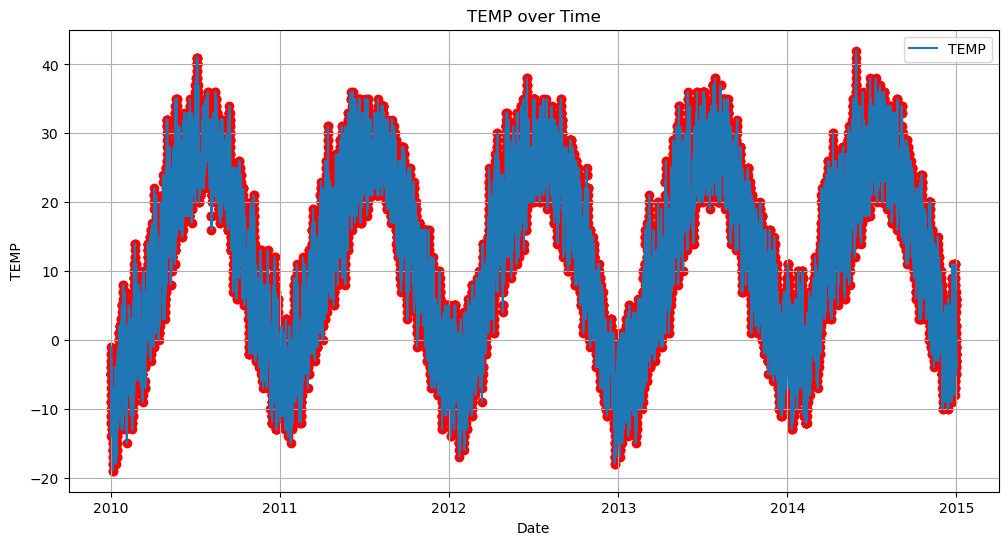

In [365]:
plot_column(df,"TEMP")

Variance: 105.44615782605663 Mean: 1016.4476542533771


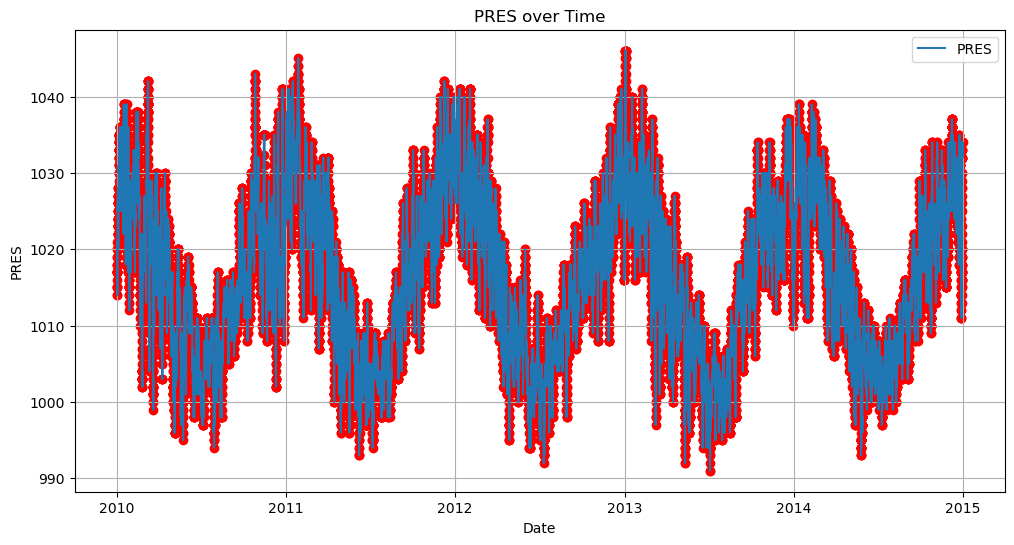

In [366]:
plot_column(df,"PRES")

Variance: 208.32419791612818 Mean: 1.817246257758306


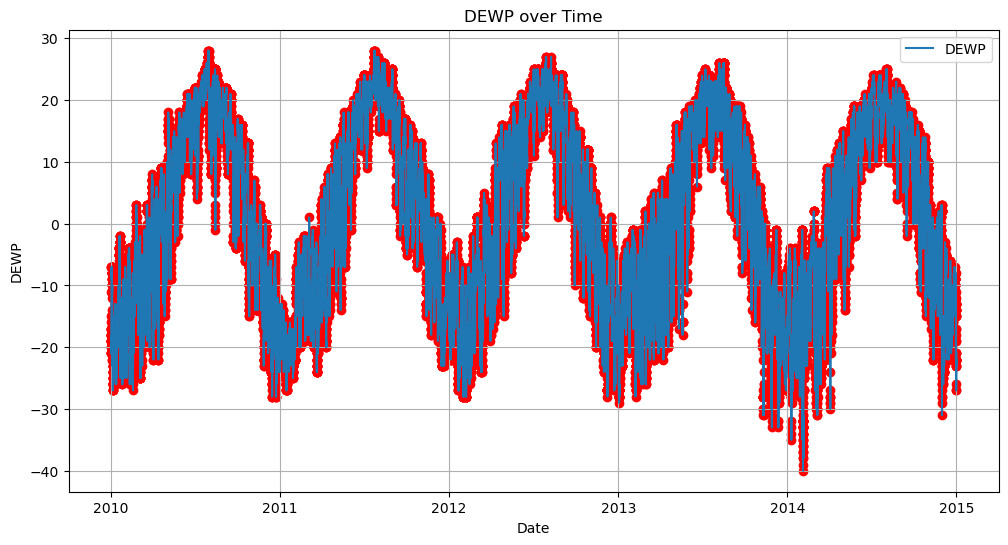

In [367]:
plot_column(df,"DEWP")

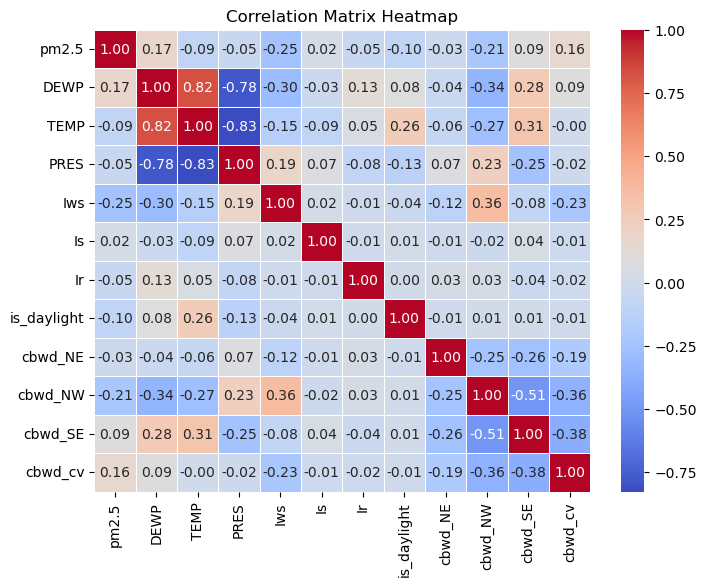

In [368]:
corr_matrix = df.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix Heatmap")
plt.show()

In [369]:
def plot_fft_and_periodogram(df, column_name):
    if column_name not in df.columns:
        raise ValueError(f"Column '{column_name}' not found in DataFrame")
    
    n = len(df[column_name])
    fft_values = fft(df[column_name].values) 
    frequencies = np.fft.fftfreq(n)  


    plt.figure(figsize=(12, 4))
    plt.plot(frequencies[:n//2], np.abs(fft_values[:n//2]))  
    plt.xlabel("Frequency")
    plt.ylabel("Magnitude")
    plt.title(f"FFT Spectrum of the Time Series {column_name}")
    plt.show()

    plt.figure(figsize=(12, 4))
    plt.semilogy(frequencies[:n//2], np.abs(fft_values[:n//2]))  
    plt.xlabel("Frequency")
    plt.ylabel("Magnitude (log scale)")
    plt.title(f"FFT Spectrum (Log Scale) {column_name}")
    plt.show()


    freqs, power = periodogram(df[column_name], fs=1)  

    plt.figure(figsize=(12, 4))
    plt.plot(freqs, power)
    plt.xlabel("Frequency")
    plt.ylabel("Power")
    plt.title(f"Periodogram of the Time Series {column_name}")
    plt.show()

    plt.figure(figsize=(12, 4))
    plt.semilogy(freqs, power)  
    plt.xlabel("Frequency")
    plt.ylabel("Power (log scale)")
    plt.title(f"Periodogram (Log Scale) {column_name}")
    plt.show()

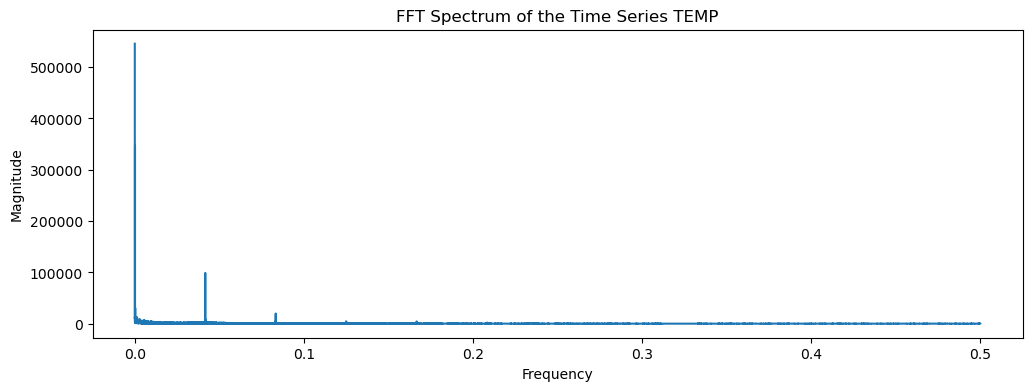

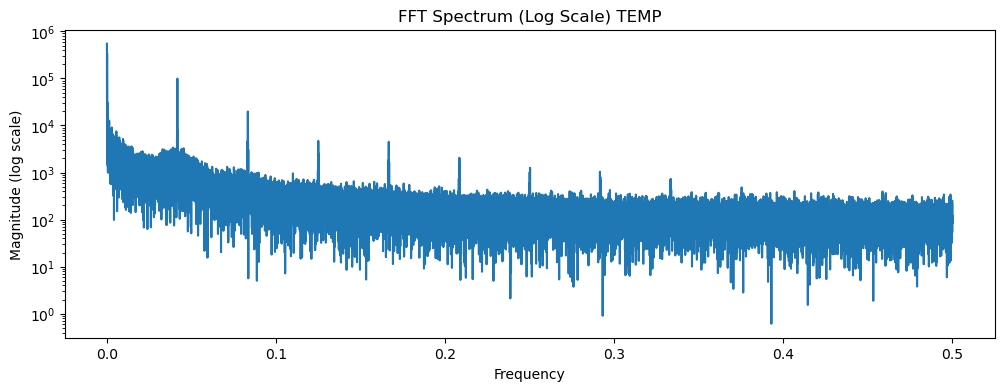

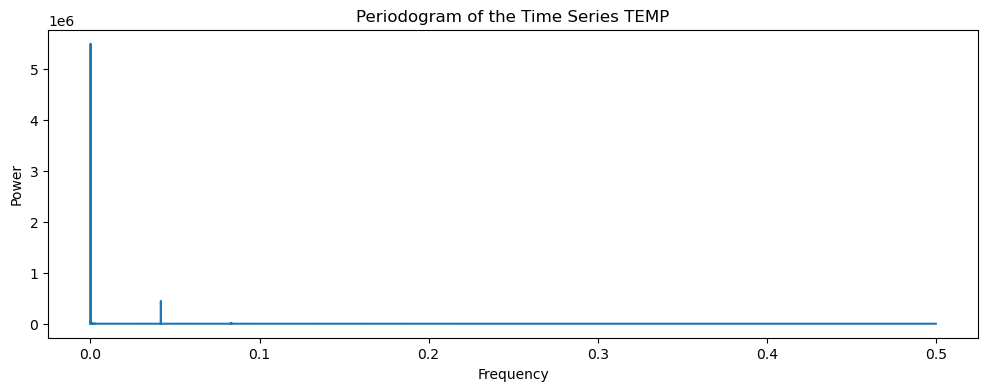

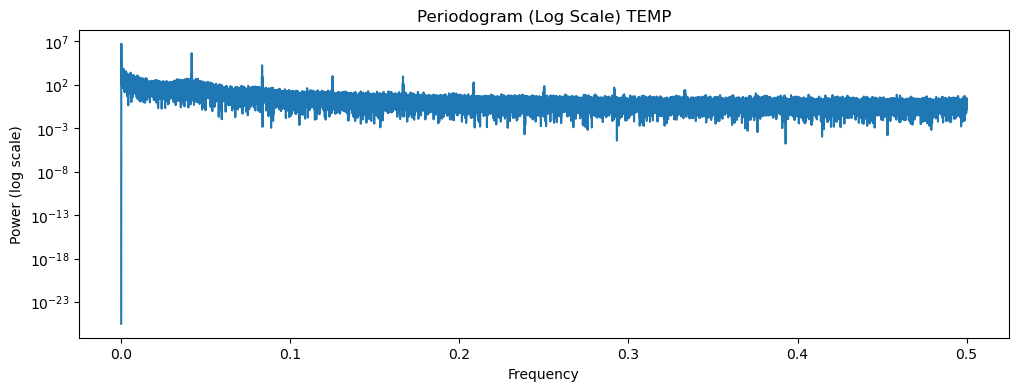

In [370]:
plot_fft_and_periodogram(df, "TEMP")

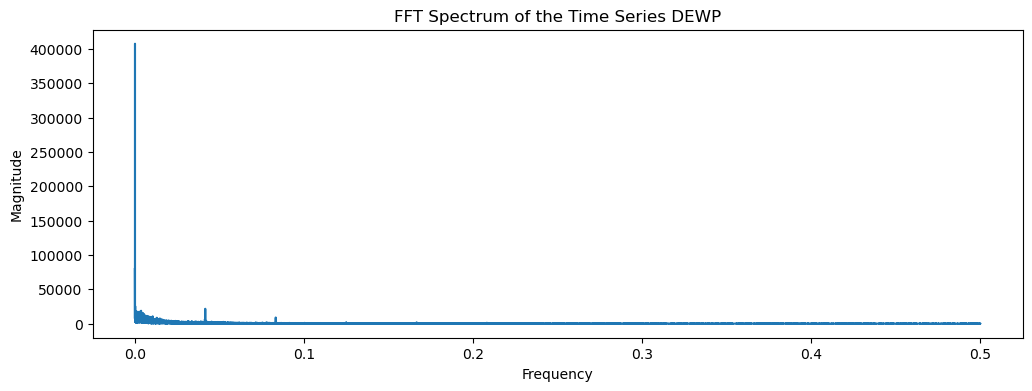

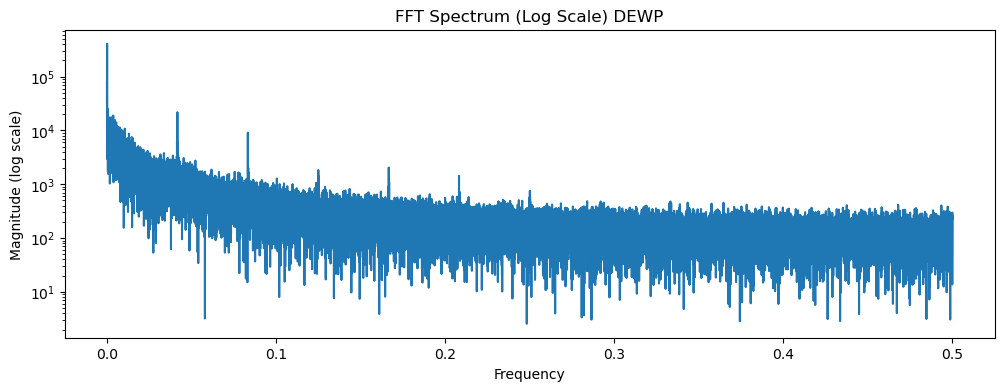

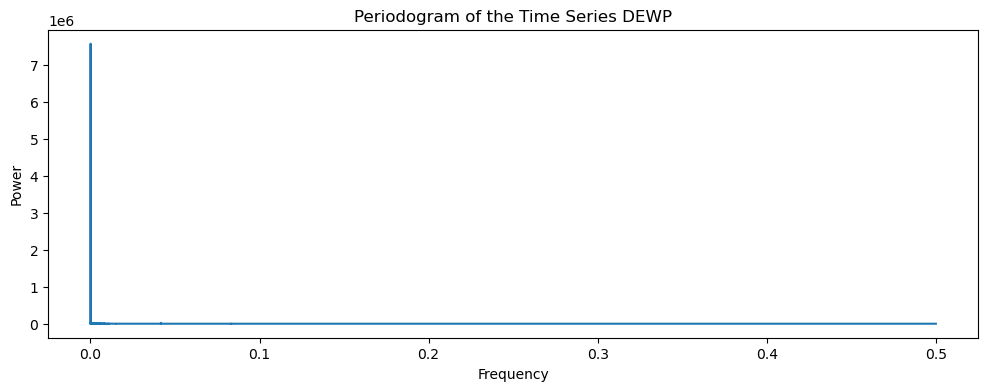

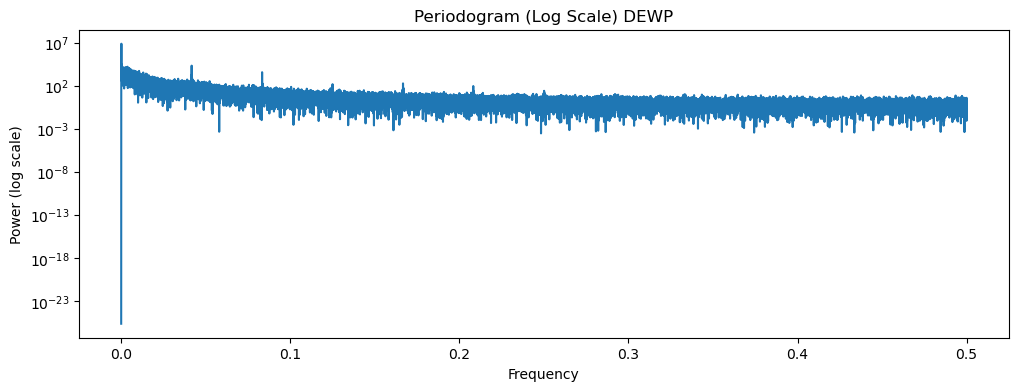

In [371]:
plot_fft_and_periodogram(df, "DEWP")

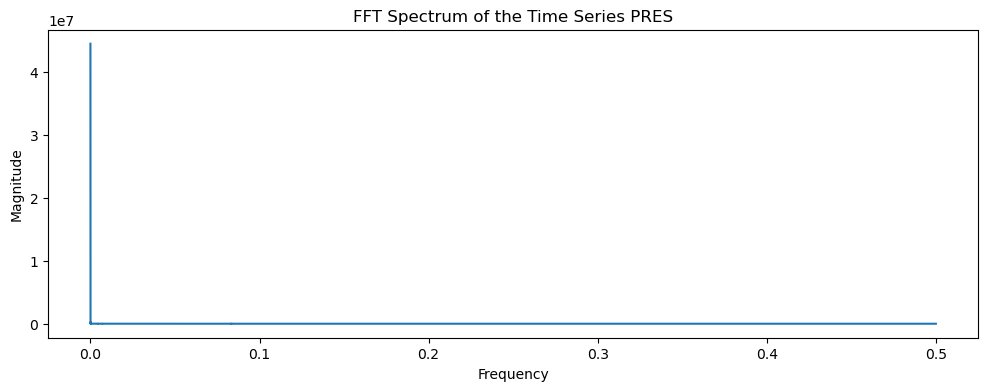

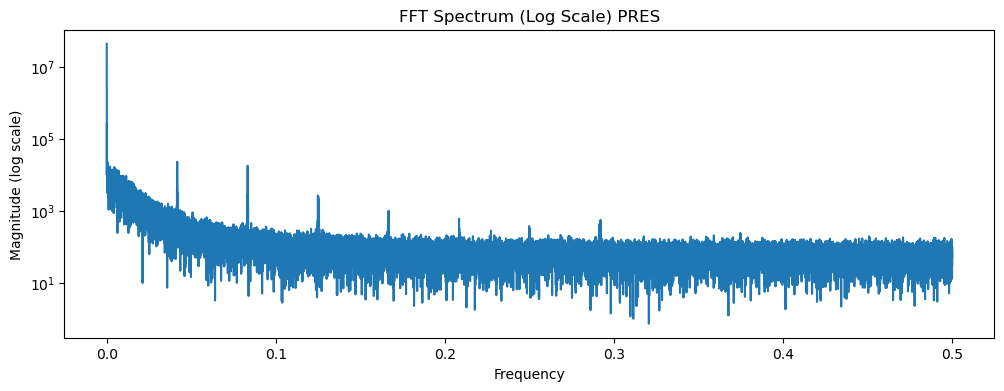

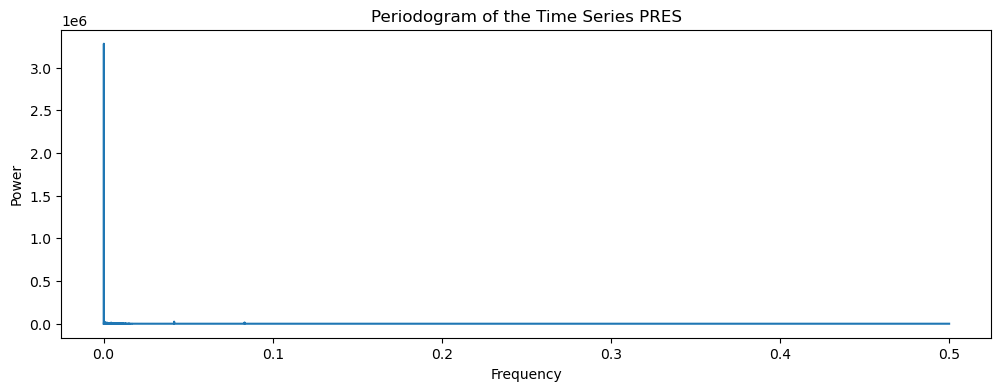

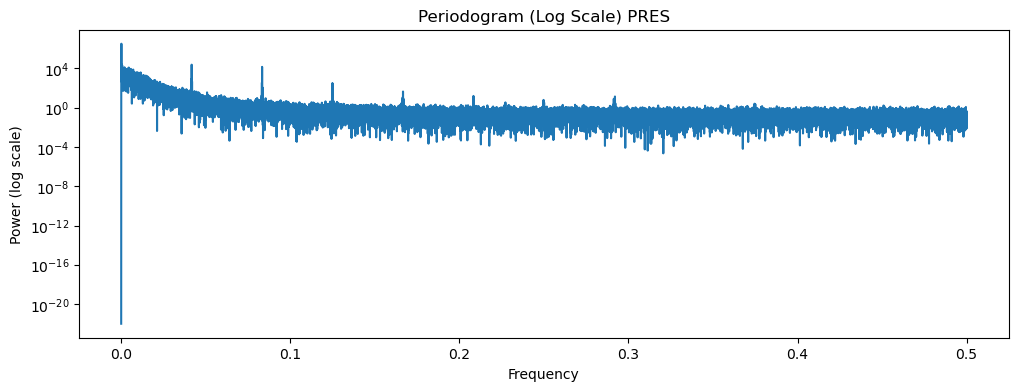

In [372]:
plot_fft_and_periodogram(df, "PRES")

In [11]:
def extract_and_merge_features(df, column_name='TEMP', n_freqs=3):
 
    daily_series = df[column_name].groupby(df.index.date).apply(list).reset_index()
    daily_series.columns = ['date', column_name]

    fft_features = []
    per_features = []

    for series in daily_series[column_name]:
        series = np.asarray(series)

        fft_vals = np.fft.fft(series)
        fft_freqs = np.fft.fftfreq(len(series))
        mask = fft_freqs > 0
        fft_vals = np.abs(fft_vals[mask])
        fft_freqs = fft_freqs[mask]
        fft_indices = np.argsort(fft_vals)[-n_freqs:]
        fft_freq_top = fft_freqs[fft_indices]
        fft_amp_top = fft_vals[fft_indices]


        freqs, psd = periodogram(series, fs=1.0)
        per_indices = np.argsort(psd)[-n_freqs:]
        per_freq_top = freqs[per_indices]
        per_power_top = psd[per_indices]

        fft_features.append(list(fft_freq_top) + list(fft_amp_top))
        per_features.append(list(per_freq_top) + list(per_power_top))

    fft_cols = [f"{column_name}_fft_freq_{i}" for i in range(n_freqs)] + \
               [f"{column_name}_fft_amp_{i}" for i in range(n_freqs)]
    per_cols = [f"{column_name}_per_freq_{i}" for i in range(n_freqs)] + \
               [f"{column_name}_per_power_{i}" for i in range(n_freqs)]

    combined_features = [f + p for f, p in zip(fft_features, per_features)]
    features_df = pd.DataFrame(combined_features,
                            columns=fft_cols + per_cols,
                            index=daily_series['date'])

    df_with_date = df.copy().reset_index()
    df_with_date['only_date'] = df_with_date['date'].dt.date

    merged_df = df_with_date.merge(features_df, left_on='only_date', right_index=True, how='left')
    merged_df = merged_df.drop(columns='only_date')
    merged_df = merged_df.set_index('date')

    return merged_df

In [12]:
def add_daily_lag_features(df, columns, lags=[1, 2, 3]):
    df = df.copy()

    if not isinstance(df.index, pd.DatetimeIndex):
        raise ValueError("DataFrame must have a DatetimeIndex.")


    daily = df[columns].resample('D').mean()
    for col in columns:
        for lag in lags:
            daily[f'{col}_lag{lag}d'] = daily[col].shift(lag)

    first_hour_values = df.groupby(df.index.date)[columns].first()
    first_hour_values.index = pd.to_datetime(first_hour_values.index)
    for col in columns:
        for lag in lags:
            lag_col = f'{col}_lag{lag}d'
            mask = daily[lag_col].isna()
            daily.loc[mask, lag_col] = first_hour_values.loc[daily.index[mask], col].values

    lagged_daily = daily[[f'{col}_lag{lag}d' for col in columns for lag in lags]]
    df['only_date'] = pd.to_datetime(df.index.date)
    lagged_daily.index = pd.to_datetime(lagged_daily.index)
    merged = df.merge(lagged_daily, left_on='only_date', right_index=True, how='left')
    merged = merged.drop(columns='only_date')

    return merged

In [13]:
def add_hourly_lag_features(df, columns, lags=[1, 2, 3]):
    df = df.copy()

    if not isinstance(df.index, pd.DatetimeIndex):
        raise ValueError("DataFrame must have a DatetimeIndex.")

    for col in columns:
        for lag in lags:
            df[f'{col}_lag{lag}h'] = df[col].shift(lag)

          
            first_valid = df[col].iloc[0]
            df[f'{col}_lag{lag}h'].fillna(first_valid, inplace=True)

    return df

In [14]:
df['month'] = df.index.month
df['day_of_year'] = df.index.dayofyear
df['season'] = pd.cut(df['day_of_year'], 
                     bins=[0, 59, 151, 242, 333,366], 
                     labels=['Winter', 'Spring', 'Summer', 'Fall','Winter'],ordered=False)

df = add_daily_lag_features(df, columns=['pm2.5', 'TEMP', 'PRES','DEWP'], lags=[1, 2, 3])
df = add_hourly_lag_features(df, columns=['pm2.5', 'TEMP', 'PRES','DEWP'], lags=[1, 2, 3])

In [15]:

df['month_sin'] = np.sin(2 * np.pi * df['month']/12)
df['month_cos'] = np.cos(2 * np.pi * df['month']/12)
df['day_of_year_sin'] = np.sin(2 * np.pi * df['day_of_year']/365.25)
df['day_of_year_cos'] = np.cos(2 * np.pi * df['day_of_year']/365.25)

In [16]:
def add_features(df, col):
    df['rolling_mean_1d'+'_'+ col] = df[col].rolling(window=24,min_periods = 1).mean()
    df['rolling_mean_1w'+'_'+ col] = df[col].rolling(window=168,min_periods = 1).mean()
    df['rolling_mean_1m'+'_'+ col] = df[col].rolling(window=720,min_periods = 1).mean()
    daily_avg = df.groupby(df.index.dayofyear)[col].transform('mean')
    df[col+'_deviation'] = df[col] - daily_avg
    seasonal_min = df.groupby('season')[col].transform('min')
    seasonal_max = df.groupby('season')[col].transform('max')
    df[col+'_normalized_by_season'] = (df[col] - seasonal_min) / (seasonal_max - seasonal_min)
    df = extract_and_merge_features(df, column_name= col, n_freqs=3)
    
    return df

In [17]:
df = add_features(df, "TEMP")
df = add_features(df, "DEWP")
df = add_features(df, "PRES")

In [18]:
df.columns

Index(['pm2.5', 'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'is_daylight',
       'cbwd_NE', 'cbwd_NW', 'cbwd_SE', 'cbwd_cv', 'month', 'day_of_year',
       'season', 'pm2.5_lag1d', 'pm2.5_lag2d', 'pm2.5_lag3d', 'TEMP_lag1d',
       'TEMP_lag2d', 'TEMP_lag3d', 'PRES_lag1d', 'PRES_lag2d', 'PRES_lag3d',
       'DEWP_lag1d', 'DEWP_lag2d', 'DEWP_lag3d', 'pm2.5_lag1h', 'pm2.5_lag2h',
       'pm2.5_lag3h', 'TEMP_lag1h', 'TEMP_lag2h', 'TEMP_lag3h', 'PRES_lag1h',
       'PRES_lag2h', 'PRES_lag3h', 'DEWP_lag1h', 'DEWP_lag2h', 'DEWP_lag3h',
       'month_sin', 'month_cos', 'day_of_year_sin', 'day_of_year_cos',
       'rolling_mean_1d_TEMP', 'rolling_mean_1w_TEMP', 'rolling_mean_1m_TEMP',
       'TEMP_deviation', 'TEMP_normalized_by_season', 'TEMP_fft_freq_0',
       'TEMP_fft_freq_1', 'TEMP_fft_freq_2', 'TEMP_fft_amp_0',
       'TEMP_fft_amp_1', 'TEMP_fft_amp_2', 'TEMP_per_freq_0',
       'TEMP_per_freq_1', 'TEMP_per_freq_2', 'TEMP_per_power_0',
       'TEMP_per_power_1', 'TEMP_per_power_2', 'rol

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 43824 entries, 2010-01-01 00:00:00 to 2014-12-31 23:00:00
Data columns (total 94 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   pm2.5                      43824 non-null  float64 
 1   DEWP                       43824 non-null  int64   
 2   TEMP                       43824 non-null  float64 
 3   PRES                       43824 non-null  float64 
 4   Iws                        43824 non-null  float64 
 5   Is                         43824 non-null  int64   
 6   Ir                         43824 non-null  int64   
 7   is_daylight                43824 non-null  int64   
 8   cbwd_NE                    43824 non-null  float64 
 9   cbwd_NW                    43824 non-null  float64 
 10  cbwd_SE                    43824 non-null  float64 
 11  cbwd_cv                    43824 non-null  float64 
 12  month                      43824 non-null  int64   
 

In [20]:
missing = df.isna().sum()
missing = missing[missing > 0]  
print(missing)

Series([], dtype: int64)


In [21]:
categorical_cols = ['season']
encoder = OneHotEncoder(sparse=False, drop=None)
encoded_array = encoder.fit_transform(df[categorical_cols])
encoded_col_names = encoder.get_feature_names_out(categorical_cols)
encoded_df = pd.DataFrame(encoded_array, columns=encoded_col_names, index=df.index)
df = pd.concat([df.drop(columns=categorical_cols), encoded_df], axis=1)

/Users/iuliuandreisteau/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


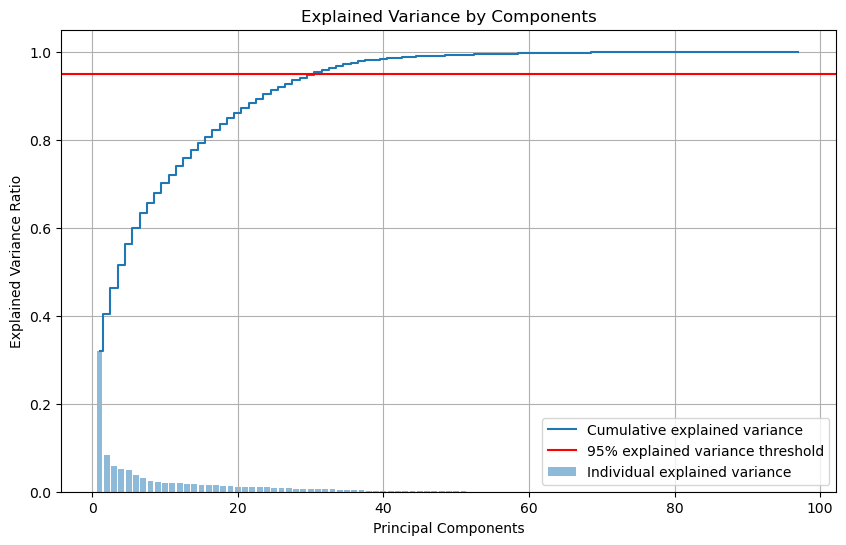

In [22]:
df_copy = df.copy()
X = df.copy()

scaler = StandardScaler()
X = scaler.fit_transform(X) 

pca = PCA()
pca_result = pca.fit_transform(X)

explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.5, label='Individual explained variance')
plt.step(range(1, len(cumulative_variance) + 1), cumulative_variance, where='mid', label='Cumulative explained variance')
plt.axhline(y=0.95, color='r', linestyle='-', label='95% explained variance threshold')
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance by Components')
plt.legend()
plt.grid()
plt.show()

Number of components needed for 95% variance: 31

Feature importance based on top components:
pm2.5_lag3d             3.835672
Ir                      3.498687
is_daylight             3.489767
cbwd_NW                 3.482387
cbwd_SE                 3.300519
                          ...   
TEMP_lag3d              0.739935
rolling_mean_1m_TEMP    0.718206
rolling_mean_1w_TEMP    0.709427
TEMP_lag1d              0.706284
rolling_mean_1d_TEMP    0.688326
Length: 97, dtype: float64

Feature importance weighted by explained variance:
PRES_normalized_by_season    0.091743
PRES                         0.085567
PRES_lag1h                   0.085157
season_Summer                0.084973
PRES_lag2h                   0.084725
                               ...   
cbwd_cv                      0.053352
DEWP_fft_freq_0              0.052998
Ir                           0.051114
Is                           0.045044
cbwd_NE                      0.040131
Length: 97, dtype: float64


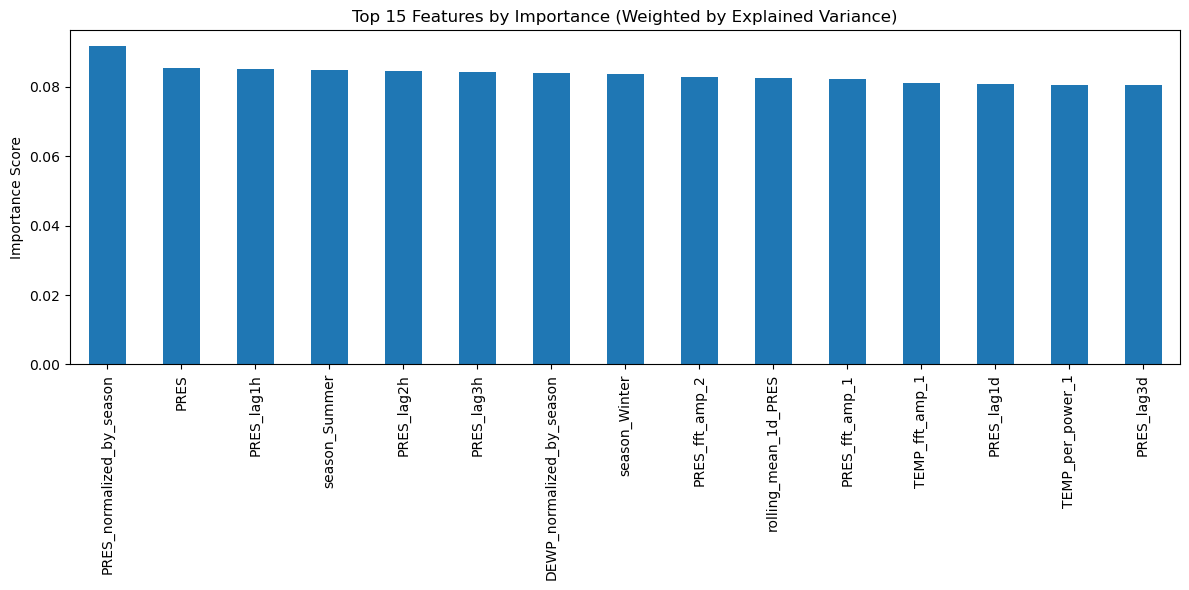

In [23]:
n_components = np.argmax(cumulative_variance >= 0.95) + 1
print(f"Number of components needed for 95% variance: {n_components}")

loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f'PC{i+1}' for i in range(pca.n_components_)],
    index=df.columns
)

abs_loadings = loadings.abs()

top_components_importance = abs_loadings.iloc[:, :n_components].sum(axis=1).sort_values(ascending=False)
print("\nFeature importance based on top components:")
print(top_components_importance)

weighted_loadings = pd.DataFrame()
for i in range(pca.n_components_):
    weighted_loadings[f'PC{i+1}'] = abs_loadings[f'PC{i+1}'] * explained_variance[i]

weighted_importance = weighted_loadings.sum(axis=1).sort_values(ascending=False)
print("\nFeature importance weighted by explained variance:")
print(weighted_importance)


plt.figure(figsize=(12, 6))
weighted_importance.head(15).plot(kind='bar')
plt.title('Top 15 Features by Importance (Weighted by Explained Variance)')
plt.ylabel('Importance Score')
plt.tight_layout()
plt.show()


In [386]:
def find_causal_features(data, target_col, max_lag=10):

    results = {}
    for col in data.columns:
        if col == target_col:
            continue

        if data[col].nunique() <= 1:
            continue

        try:
            test_pair = data[[target_col, col]]
            test_result = grangercausalitytests(test_pair, maxlag=max_lag, verbose=False)
      
            p_values = [test_result[i + 1][0]['ssr_ftest'][1] for i in range(max_lag)]
            results[col] = p_values
        except Exception as e:
            print(f"Skipped {col} due to error: {e}")
            continue

    return results

In [387]:
granger_results = find_causal_features(df, 'TEMP', max_lag=20)

print("Granger Causality Test Results (H0: Feature does not Granger-cause target) TEMP")
print("------------------------------------------------------------------")
for col, p_values in granger_results.items():
    min_p_value = min(p_values)
    best_lag = p_values.index(min_p_value) + 1  # +1 because lags are 1-indexed
    significance = "Significant" if min_p_value < 0.05 else "Not significant"
    print(f"{col}: p-value = {min_p_value:.6f}, Best lag = {best_lag}, {significance}")

Granger Causality Test Results (H0: Feature does not Granger-cause target) TEMP
------------------------------------------------------------------
pm2.5: p-value = 0.000000, Best lag = 15, Significant
DEWP: p-value = 0.000000, Best lag = 3, Significant
PRES: p-value = 0.000000, Best lag = 13, Significant
Iws: p-value = 0.000000, Best lag = 1, Significant
Is: p-value = 0.047698, Best lag = 18, Significant
Ir: p-value = 0.000000, Best lag = 20, Significant
is_daylight: p-value = 0.000000, Best lag = 1, Significant
cbwd_NE: p-value = 0.000000, Best lag = 2, Significant
cbwd_NW: p-value = 0.000000, Best lag = 1, Significant
cbwd_SE: p-value = 0.000000, Best lag = 1, Significant
cbwd_cv: p-value = 0.000000, Best lag = 4, Significant
month: p-value = 0.001349, Best lag = 4, Significant
day_of_year: p-value = 0.001367, Best lag = 4, Significant
pm2.5_lag1d: p-value = 0.000000, Best lag = 20, Significant
pm2.5_lag2d: p-value = 0.000000, Best lag = 20, Significant
pm2.5_lag3d: p-value = 0.00557

In [388]:
granger_results = find_causal_features(df, 'DEWP', max_lag=20)

print("Granger Causality Test Results (H0: Feature does not Granger-cause target) DEWP")
print("------------------------------------------------------------------")
for col, p_values in granger_results.items():
    min_p_value = min(p_values)
    best_lag = p_values.index(min_p_value) + 1  # +1 because lags are 1-indexed
    significance = "Significant" if min_p_value < 0.05 else "Not significant"
    print(f"{col}: p-value = {min_p_value:.6f}, Best lag = {best_lag}, {significance}")

Granger Causality Test Results (H0: Feature does not Granger-cause target) DEWP
------------------------------------------------------------------
pm2.5: p-value = 0.000000, Best lag = 13, Significant
TEMP: p-value = 0.000000, Best lag = 2, Significant
PRES: p-value = 0.000000, Best lag = 20, Significant
Iws: p-value = 0.000002, Best lag = 2, Significant
Is: p-value = 0.000193, Best lag = 15, Significant
Ir: p-value = 0.465393, Best lag = 2, Not significant
is_daylight: p-value = 0.000000, Best lag = 11, Significant
cbwd_NE: p-value = 0.000000, Best lag = 1, Significant
cbwd_NW: p-value = 0.000000, Best lag = 15, Significant
cbwd_SE: p-value = 0.000000, Best lag = 20, Significant
cbwd_cv: p-value = 0.000283, Best lag = 4, Significant
month: p-value = 0.267985, Best lag = 1, Not significant
day_of_year: p-value = 0.247718, Best lag = 1, Not significant
pm2.5_lag1d: p-value = 0.000000, Best lag = 20, Significant
pm2.5_lag2d: p-value = 0.000000, Best lag = 20, Significant
pm2.5_lag3d: p-v

In [389]:
granger_results = find_causal_features(df, 'PRES', max_lag=20)

print("Granger Causality Test Results (H0: Feature does not Granger-cause target) PRES ")
print("------------------------------------------------------------------")
for col, p_values in granger_results.items():
    min_p_value = min(p_values)
    best_lag = p_values.index(min_p_value) + 1  # +1 because lags are 1-indexed
    significance = "Significant" if min_p_value < 0.05 else "Not significant"
    print(f"{col}: p-value = {min_p_value:.6f}, Best lag = {best_lag}, {significance}")

Granger Causality Test Results (H0: Feature does not Granger-cause target) PRES 
------------------------------------------------------------------
pm2.5: p-value = 0.000000, Best lag = 20, Significant
DEWP: p-value = 0.000000, Best lag = 20, Significant
TEMP: p-value = 0.000000, Best lag = 2, Significant
Iws: p-value = 0.000000, Best lag = 20, Significant
Is: p-value = 0.008391, Best lag = 14, Significant
Ir: p-value = 0.002815, Best lag = 3, Significant
is_daylight: p-value = 0.000000, Best lag = 1, Significant
cbwd_NE: p-value = 0.000000, Best lag = 1, Significant
cbwd_NW: p-value = 0.000000, Best lag = 20, Significant
cbwd_SE: p-value = 0.000000, Best lag = 20, Significant
cbwd_cv: p-value = 0.000000, Best lag = 20, Significant
month: p-value = 0.020576, Best lag = 19, Significant
day_of_year: p-value = 0.010600, Best lag = 19, Significant
pm2.5_lag1d: p-value = 0.000000, Best lag = 1, Significant
pm2.5_lag2d: p-value = 0.000000, Best lag = 1, Significant
pm2.5_lag3d: p-value = 0.4

/Users/iuliuandreisteau/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


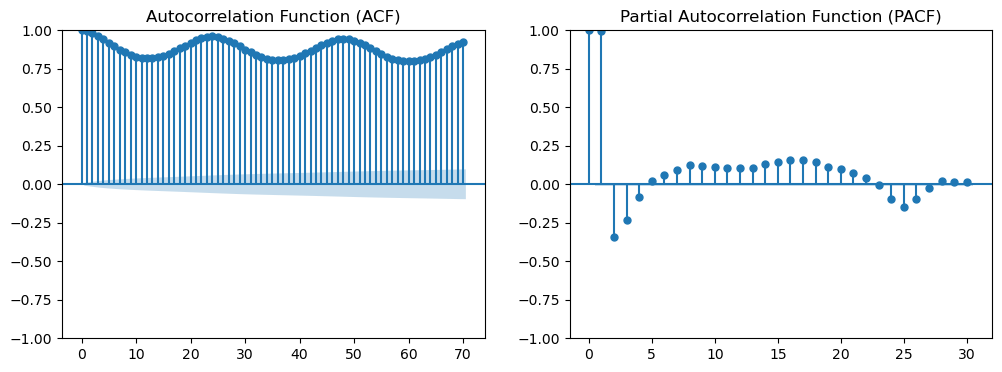

In [390]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

plot_acf(df["TEMP"], lags=70, ax=axes[0])
axes[0].set_title("Autocorrelation Function (ACF)")

plot_pacf(df["TEMP"], lags=30, ax=axes[1])
axes[1].set_title("Partial Autocorrelation Function (PACF)")

plt.show()

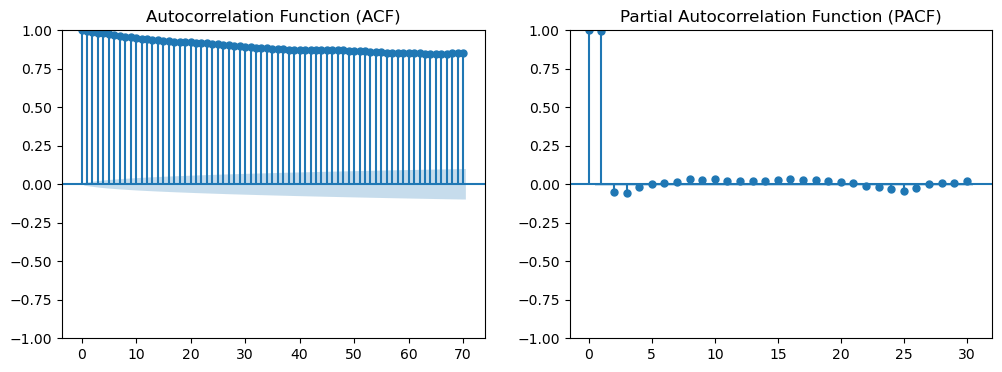

In [391]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

plot_acf(df["DEWP"], lags=70, ax=axes[0])
axes[0].set_title("Autocorrelation Function (ACF)")

plot_pacf(df["DEWP"], lags=30, ax=axes[1])
axes[1].set_title("Partial Autocorrelation Function (PACF)")

plt.show()

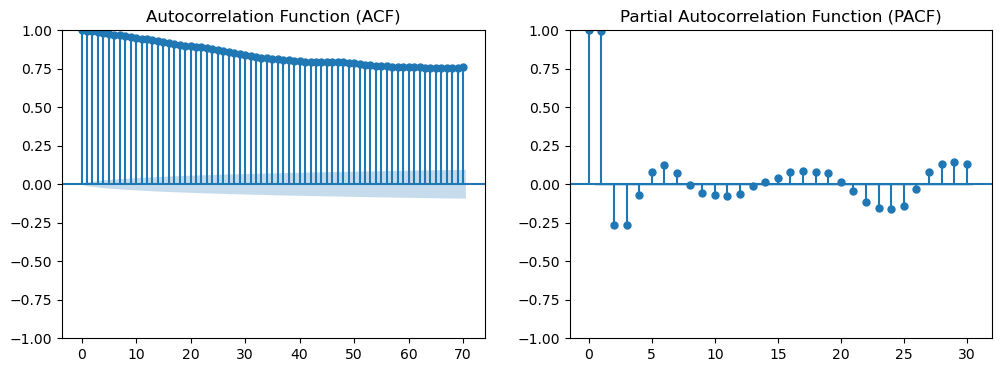

In [392]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

plot_acf(df["PRES"], lags=70, ax=axes[0])
axes[0].set_title("Autocorrelation Function (ACF)")

plot_pacf(df["PRES"], lags=30, ax=axes[1])
axes[1].set_title("Partial Autocorrelation Function (PACF)")

plt.show()

In [393]:
df

pm2.5  DEWP  TEMP    PRES     Iws  Is  Ir  is_daylight  \
date                                                                          
2010-01-01 00:00:00  162.8   -21 -11.0  1021.0    1.79   0   0            0   
2010-01-01 01:00:00  137.0   -21 -12.0  1020.0    4.92   0   0            0   
2010-01-01 02:00:00  142.0   -21 -11.0  1019.0    6.71   0   0            0   
2010-01-01 03:00:00   89.4   -21 -14.0  1019.0    9.84   0   0            0   
2010-01-01 04:00:00   83.4   -20 -12.0  1018.0   12.97   0   0            0   
...                    ...   ...   ...     ...     ...  ..  ..          ...   
2014-12-31 19:00:00    8.0   -23  -2.0  1034.0  231.97   0   0            0   
2014-12-31 20:00:00   10.0   -22  -3.0  1034.0  237.78   0   0            0   
2014-12-31 21:00:00   10.0   -22  -3.0  1034.0  242.70   0   0            0   
2014-12-31 22:00:00    8.0   -22  -4.0  1034.0  246.72   0   0            0   
2014-12-31 23:00:00   12.0   -21  -3.0  1034.0  249.85   0   0            0   

                     cbwd_NE  cbwd_NW  ...  PRES_per_freq_0  PRES_per_freq_1  \
date                                   ...                                     
2010-01-01 00:00:00      0.0      1.0  ...            0.125         0.083333   
2010-01-01 01:00:00      0.0      1.0  ...            0.125         0.083333   
2010-01-01 02:00:00      0.0      1.0  ...            0.125         0.083333   
2010-01-01 03:00:00      0.0      1.0  ...            0.125         0.083333   
2010-01-01 04:00:00      0.0      1.0  ...            0.125         0.083333   
...                      ...      ...  ...              ...              ...   
2014-12-31 19:00:00      0.0      1.0  ...            0.250         0.041667   
2014-12-31 20:00:00      0.0      1.0  ...            0.250         0.041667   
2014-12-31 21:00:00      0.0      1.0  ...            0.250         0.041667   
2014-12-31 22:00:00      0.0      1.0  ...            0.250         0.041667   
2014-12-31 23:00:00      0.0      1.0  ...            0.250         0.041667   

                     PRES_per_freq_2  PRES_per_power_0  PRES_per_power_1  \
date                                                                       
2010-01-01 00:00:00         0.041667           3.58088          9.929806   
2010-01-01 01:00:00         0.041667           3.58088          9.929806   
2010-01-01 02:00:00         0.041667           3.58088          9.929806   
2010-01-01 03:00:00         0.041667           3.58088          9.929806   
2010-01-01 04:00:00         0.041667           3.58088          9.929806   
...                              ...               ...               ...   
2014-12-31 19:00:00         0.083333           3.75000         34.422304   
2014-12-31 20:00:00         0.083333           3.75000         34.422304   
2014-12-31 21:00:00         0.083333           3.75000         34.422304   
2014-12-31 22:00:00         0.083333           3.75000         34.422304   
2014-12-31 23:00:00         0.083333           3.75000         34.422304   

                     PRES_per_power_2  season_Fall  season_Spring  \
date                                                                
2010-01-01 00:00:00         62.709409          0.0            0.0   
2010-01-01 01:00:00         62.709409          0.0            0.0   
2010-01-01 02:00:00         62.709409          0.0            0.0   
2010-01-01 03:00:00         62.709409          0.0            0.0   
2010-01-01 04:00:00         62.709409          0.0            0.0   
...                               ...          ...            ...   
2014-12-31 19:00:00         60.877876          0.0            0.0   
2014-12-31 20:00:00         60.877876          0.0            0.0   
2014-12-31 21:00:00         60.877876          0.0            0.0   
2014-12-31 22:00:00         60.877876          0.0            0.0   
2014-12-31 23:00:00         60.877876          0.0            0.0   

                     season_Summer  season_Winter  
date         

In [69]:
df_rf = df.copy()
# df_rf = df_rf[weighted_importance.head(15).index]
cbwd_columns = [col for col in df.columns if col.startswith("cbwd_")]
df_rf['cbwd'] = df[cbwd_columns].idxmax(axis=1).str.replace('cbwd_', '')
df_rf = df_rf.drop(columns=[col for col in df_rf.columns if col.startswith("cbwd_")])
# df_rf = df_rf.drop(columns=["DEWP", "PRES"])

In [30]:

# # Sort by time
# df_rf = df_rf.sort_index()

# target_n = 4997
# n_bins = 50  # Number of temporal bins per class

# balanced_chunks = []

# for label, group in df_rf.groupby('cbwd'):
#     group = group.sort_index()
    
#     # Break into time bins
#     bins = pd.qcut(group.index.astype(np.int64), q=n_bins, duplicates='drop')
#     group = group.copy()
#     group['bin'] = bins
    
#     # Samples per bin (try to evenly split)
#     samples_per_bin = target_n // n_bins
#     remainder = target_n % n_bins
    
#     # Perform bin-wise sampling
#     sampled = []
#     for i, (bin_val, bin_group) in enumerate(group.groupby('bin')):
#         n_samples = samples_per_bin + (1 if i < remainder else 0)
#         n_samples = min(n_samples, len(bin_group))  # Just in case bin is smaller
#         sampled.append(bin_group.sample(n=n_samples, random_state=42))

#     result = pd.concat(sampled).sort_index()
#     balanced_chunks.append(result.drop(columns='bin'))

# # Combine and preserve time order
# df_rf= pd.concat(balanced_chunks).sort_index()

In [31]:
df_rf.columns

Index(['pm2.5', 'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'is_daylight',
       'month', 'day_of_year', 'pm2.5_lag1d', 'pm2.5_lag2d', 'pm2.5_lag3d',
       'TEMP_lag1d', 'TEMP_lag2d', 'TEMP_lag3d', 'PRES_lag1d', 'PRES_lag2d',
       'PRES_lag3d', 'DEWP_lag1d', 'DEWP_lag2d', 'DEWP_lag3d', 'pm2.5_lag1h',
       'pm2.5_lag2h', 'pm2.5_lag3h', 'TEMP_lag1h', 'TEMP_lag2h', 'TEMP_lag3h',
       'PRES_lag1h', 'PRES_lag2h', 'PRES_lag3h', 'DEWP_lag1h', 'DEWP_lag2h',
       'DEWP_lag3h', 'month_sin', 'month_cos', 'day_of_year_sin',
       'day_of_year_cos', 'rolling_mean_1d_TEMP', 'rolling_mean_1w_TEMP',
       'rolling_mean_1m_TEMP', 'TEMP_deviation', 'TEMP_normalized_by_season',
       'TEMP_fft_freq_0', 'TEMP_fft_freq_1', 'TEMP_fft_freq_2',
       'TEMP_fft_amp_0', 'TEMP_fft_amp_1', 'TEMP_fft_amp_2', 'TEMP_per_freq_0',
       'TEMP_per_freq_1', 'TEMP_per_freq_2', 'TEMP_per_power_0',
       'TEMP_per_power_1', 'TEMP_per_power_2', 'rolling_mean_1d_DEWP',
       'rolling_mean_1w_DEWP', 'rolling_m

In [32]:
def plot_column_with_cbwd(df, column_name, cbwd_column='cbwd', start_year=None, start_month=None, num_months=None):
    if column_name not in df.columns or cbwd_column not in df.columns:
        raise ValueError(f"Column '{column_name}' or '{cbwd_column}' not found in DataFrame")

    if start_year is not None or start_month is not None or num_months is not None:
        start_date = pd.Timestamp(year=start_year, month=start_month, day=1)
        end_date = start_date + pd.DateOffset(months=num_months)
        df_filtered = df.loc[start_date:end_date]
    else:
        df_filtered = df

    print("Variance:", df_filtered[column_name].var(), "Mean:", df_filtered[column_name].mean())
    plt.figure(figsize=(14, 6))
    plt.plot(df_filtered[column_name], linestyle='-', color='gray', alpha=0.5, label=column_name)


    cbwd_colors = {'SE': 'blue', 'NW': 'green', 'cv': 'purple', 'NE': 'orange'}
    for cbwd_class, color in cbwd_colors.items():
        class_df = df_filtered[df_filtered[cbwd_column] == cbwd_class]
        plt.scatter(class_df.index, class_df[column_name], label=f'{cbwd_class}', color=color, s=10)

    plt.xlabel("Date")
    plt.ylabel(column_name)
    plt.title(f"{column_name} over Time with cbwd Categories")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Variance: 148.80615399232963 Mean: 12.448521358159981


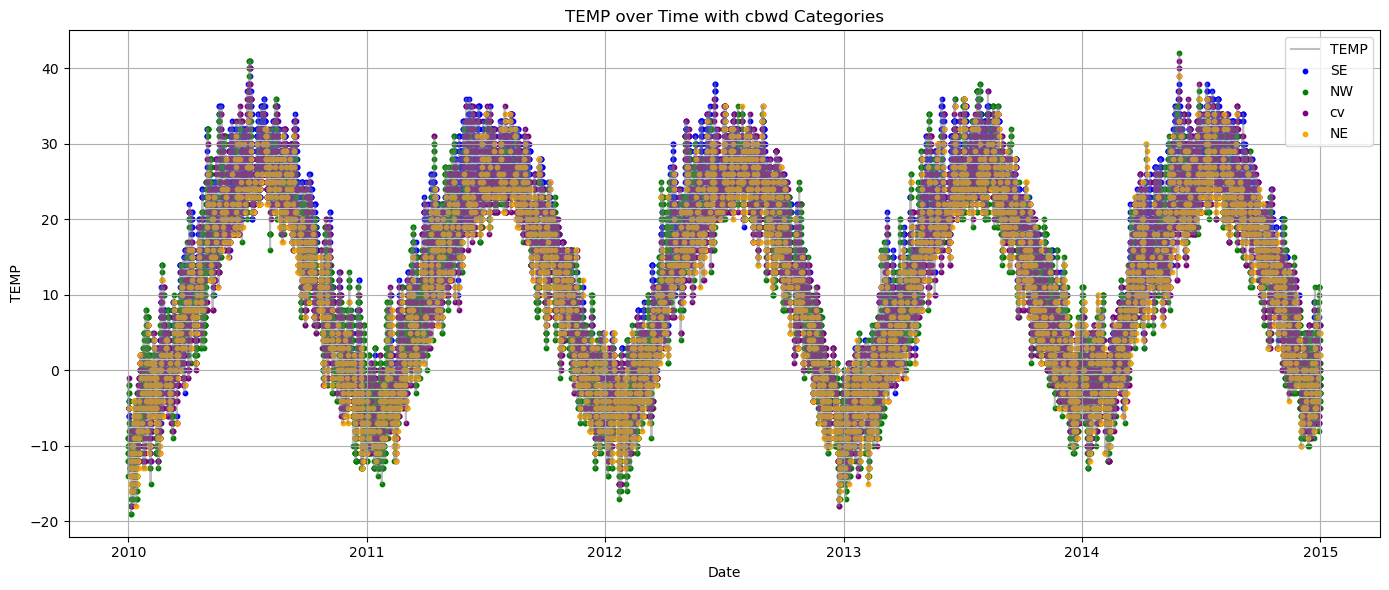

In [33]:
plot_column_with_cbwd(df_rf, column_name='TEMP')

Variance: 208.32419791612818 Mean: 1.817246257758306


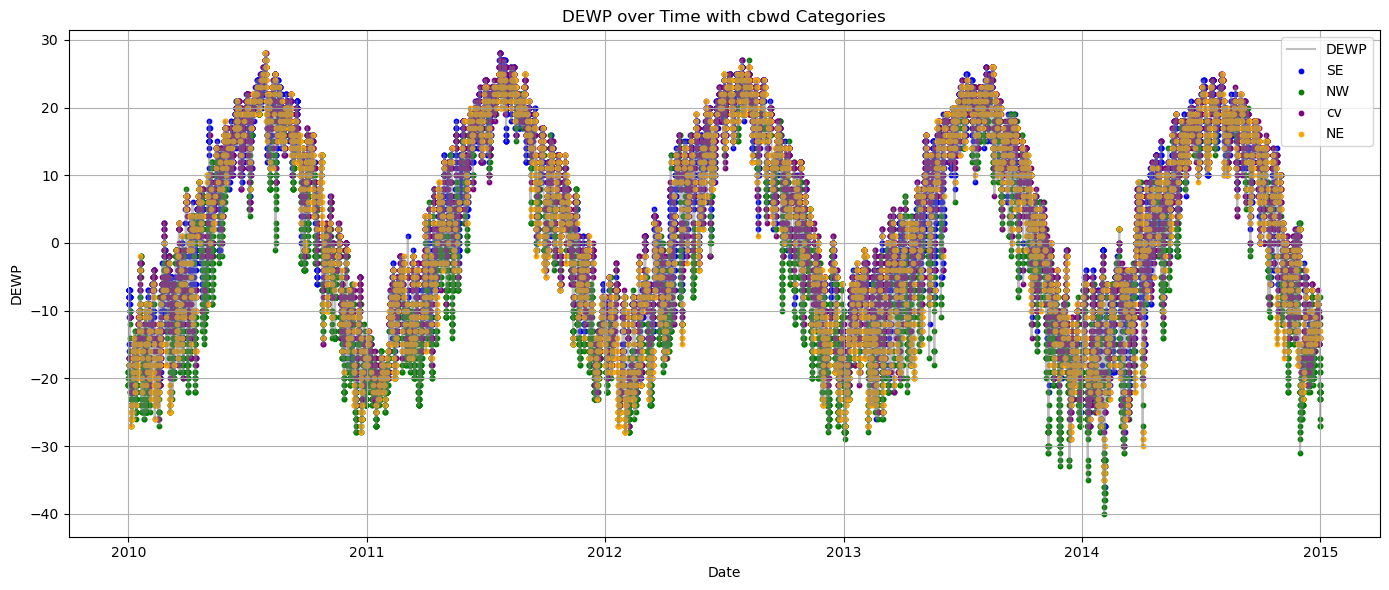

In [34]:
plot_column_with_cbwd(df_rf, column_name='DEWP')

Variance: 105.44615782605663 Mean: 1016.4476542533771


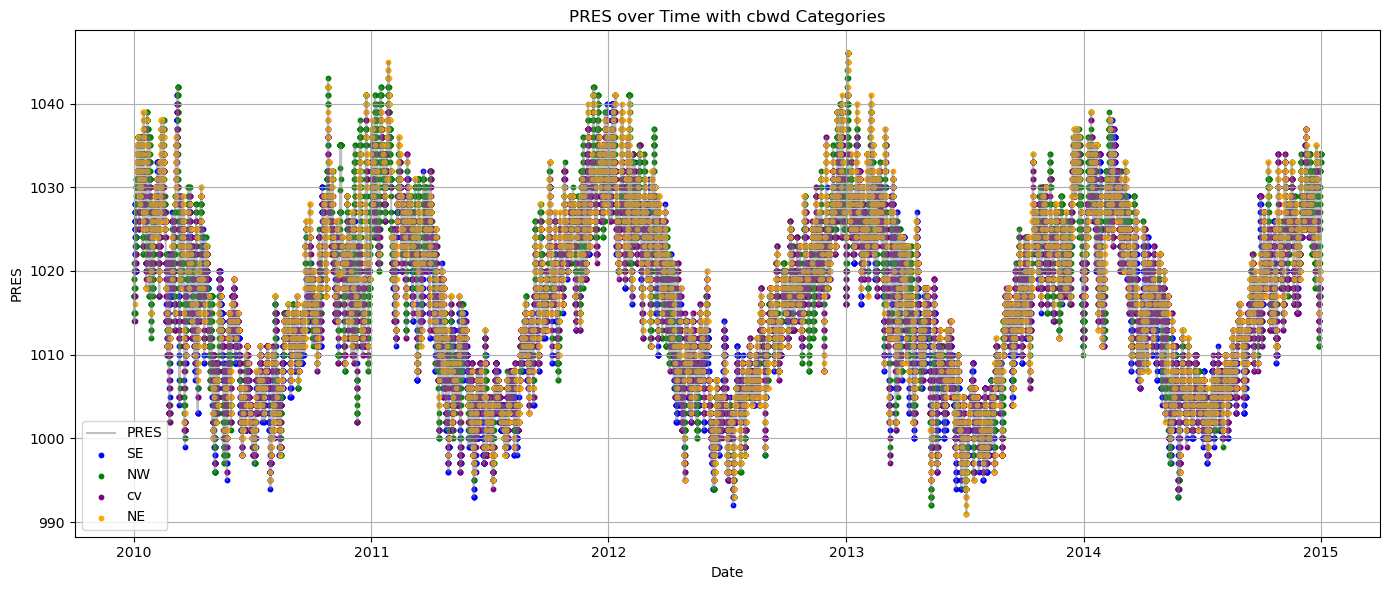

In [35]:
plot_column_with_cbwd(df_rf, column_name='PRES')

In [37]:
def create_sequences_df(df, seq_length, horizon=1, target_col='cbwd'):
    xs, ys = [], []
    feature_cols = [col for col in df.columns if col != target_col]
    data = df[feature_cols].values
    target = df[target_col].values

    for i in range(len(data) - seq_length - horizon + 1):
        x = data[i:i + seq_length]
        y = target[i + seq_length + horizon - 1]
        xs.append(x)
        ys.append(y)

    return np.array(xs), np.array(ys)

X_seq, y_seq = create_sequences_df(df_rf, seq_length=24, horizon=1, target_col='cbwd')
print(f"X_seq shape: {X_seq.shape}")  # Should be (n_samples, timepoints, variables)
print("🧬 Converting to sktime nested format...")
# X_nested = from_3d_numpy_to_nested(X_seq)

X_seq shape: (43800, 24, 93)
🧬 Converting to sktime nested format...


In [38]:
# print("🧪 Splitting data (temporal)...")
# split_idx = int(len(X_nested) * (1 - 0.3))
# X_train, X_test = X_nested.iloc[:split_idx], X_nested.iloc[split_idx:]
# y_train, y_test = y_seq[:split_idx], y_seq[split_idx:]

# print("Training model...")
# clf = HIVECOTEV2(
#     drcif_params={"n_estimators": 250},
#     tde_params={"max_ensemble_size": 25},
#     n_jobs=-1
# )
# clf.fit(X_train, y_train)

# # estimators = [
# #     (f"var_{i}", TimeSeriesForestClassifier(n_estimators=150, random_state=42,n_jobs=-1), i)
# #     for i in range(X_train.shape[1])
# # ]

# # clf = ColumnEnsembleClassifier(estimators=estimators)
# # clf.fit(X_train, y_train)

# print("🔍 Evaluating...")
# y_pred = clf.predict(X_test)
# print(classification_report(y_test, y_pred))


In [ ]:
X_seq, y_seq = create_sequences_df(df_rf, seq_length=72, horizon=1, target_col='cbwd')
print(f"X_seq shape: {X_seq.shape}")  # (n_samples, seq_length, features)

le = LabelEncoder()
y_seq = le.fit_transform(y_seq)
X_flat = X_seq.reshape(X_seq.shape[0], -1)
print(f"X_flat shape: {X_flat.shape}")  # (n_samples, seq_length * features)

X_seq shape: (43752, 72, 93)


In [40]:
def compute_confusion_metrics(cm):
    FN = []
    FP = []
    TP = []
    TN = []
    for i in range(len(cm)):
        tp = cm[i, i]
        fp = cm[:, i].sum() - tp
        fn = cm[i, :].sum() - tp
        tn = cm.sum() - (tp + fp + fn)
        TP.append(tp)
        FP.append(fp)
        FN.append(fn)
        TN.append(tn)
    return TP, FP, FN, TN

Training XGBoost model...
{'objective': 'multi:softmax', 'base_score': None, 'booster': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'eval_metric': 'mlogloss', 'gamma': None, 'gpu_id': None, 'grow_policy': None, 'interaction_constraints': None, 'learning_rate': 0.01, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 5, 'max_leaves': None, 'min_child_weight': None, 'monotone_constraints': None, 'n_jobs': -1, 'num_parallel_tree': None, 'predictor': None, 'random_state': 42, 'reg_alpha': 2, 'reg_lambda': 20, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': 'hist', 'validate_parameters': None, 'verbosity': None}
🔍 Evaluating...
              precision    recall  f1-score   support

           0       0.19      0.21      0.20      1502
           1       0.71      0.48      0.57      3998
           2       0.68      0.61      0.65      4495
           3     

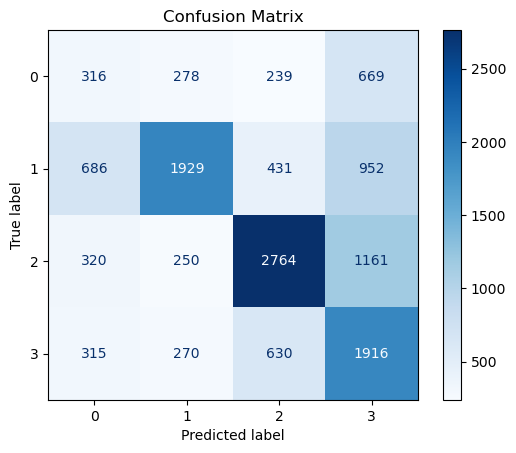

In [57]:

split_idx = int(len(X_flat) * (1 - 0.3))
X_train, X_test = X_flat[:split_idx], X_flat[split_idx:]
y_train, y_test = y_seq[:split_idx], y_seq[split_idx:]

classes = np.unique(y_train)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weight_dict = dict(zip(classes, class_weights))

sample_weight = np.array([class_weight_dict[label] for label in y_train])

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print("Training XGBoost model...")
clf = XGBClassifier(
    n_estimators=50,
    learning_rate=0.01,
    random_state=42,
    n_jobs=-1,
    objective="multi:softmax",
    reg_alpha =  2,
    reg_lambda = 20,
    max_depth=5,
    tree_method = 'hist',
    eval_metric = 'mlogloss'
)
print(clf.get_xgb_params())
clf.fit(X_train, y_train, sample_weight=sample_weight)

print("🔍 Evaluating...")
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_seq))
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()


In [43]:
TP, FP, FN, TN = compute_confusion_metrics(cm)

for i, cls in enumerate(le.classes_):
    print(f"\nClass: {cls}")
    print(f"  TP: {TP[i]}")
    print(f"  TN: {TN[i]}")
    print(f"  FP: {FP[i]}")
    print(f"  FN: {FN[i]}")


Class: NE
  TP: 236
  TN: 10643
  FP: 981
  FN: 1266

Class: NW
  TP: 2169
  TN: 8229
  FP: 899
  FN: 1829

Class: SE
  TP: 2821
  TN: 7356
  FP: 1275
  FN: 1674

Class: cv
  TP: 1935
  TN: 7185
  FP: 2810
  FN: 1196


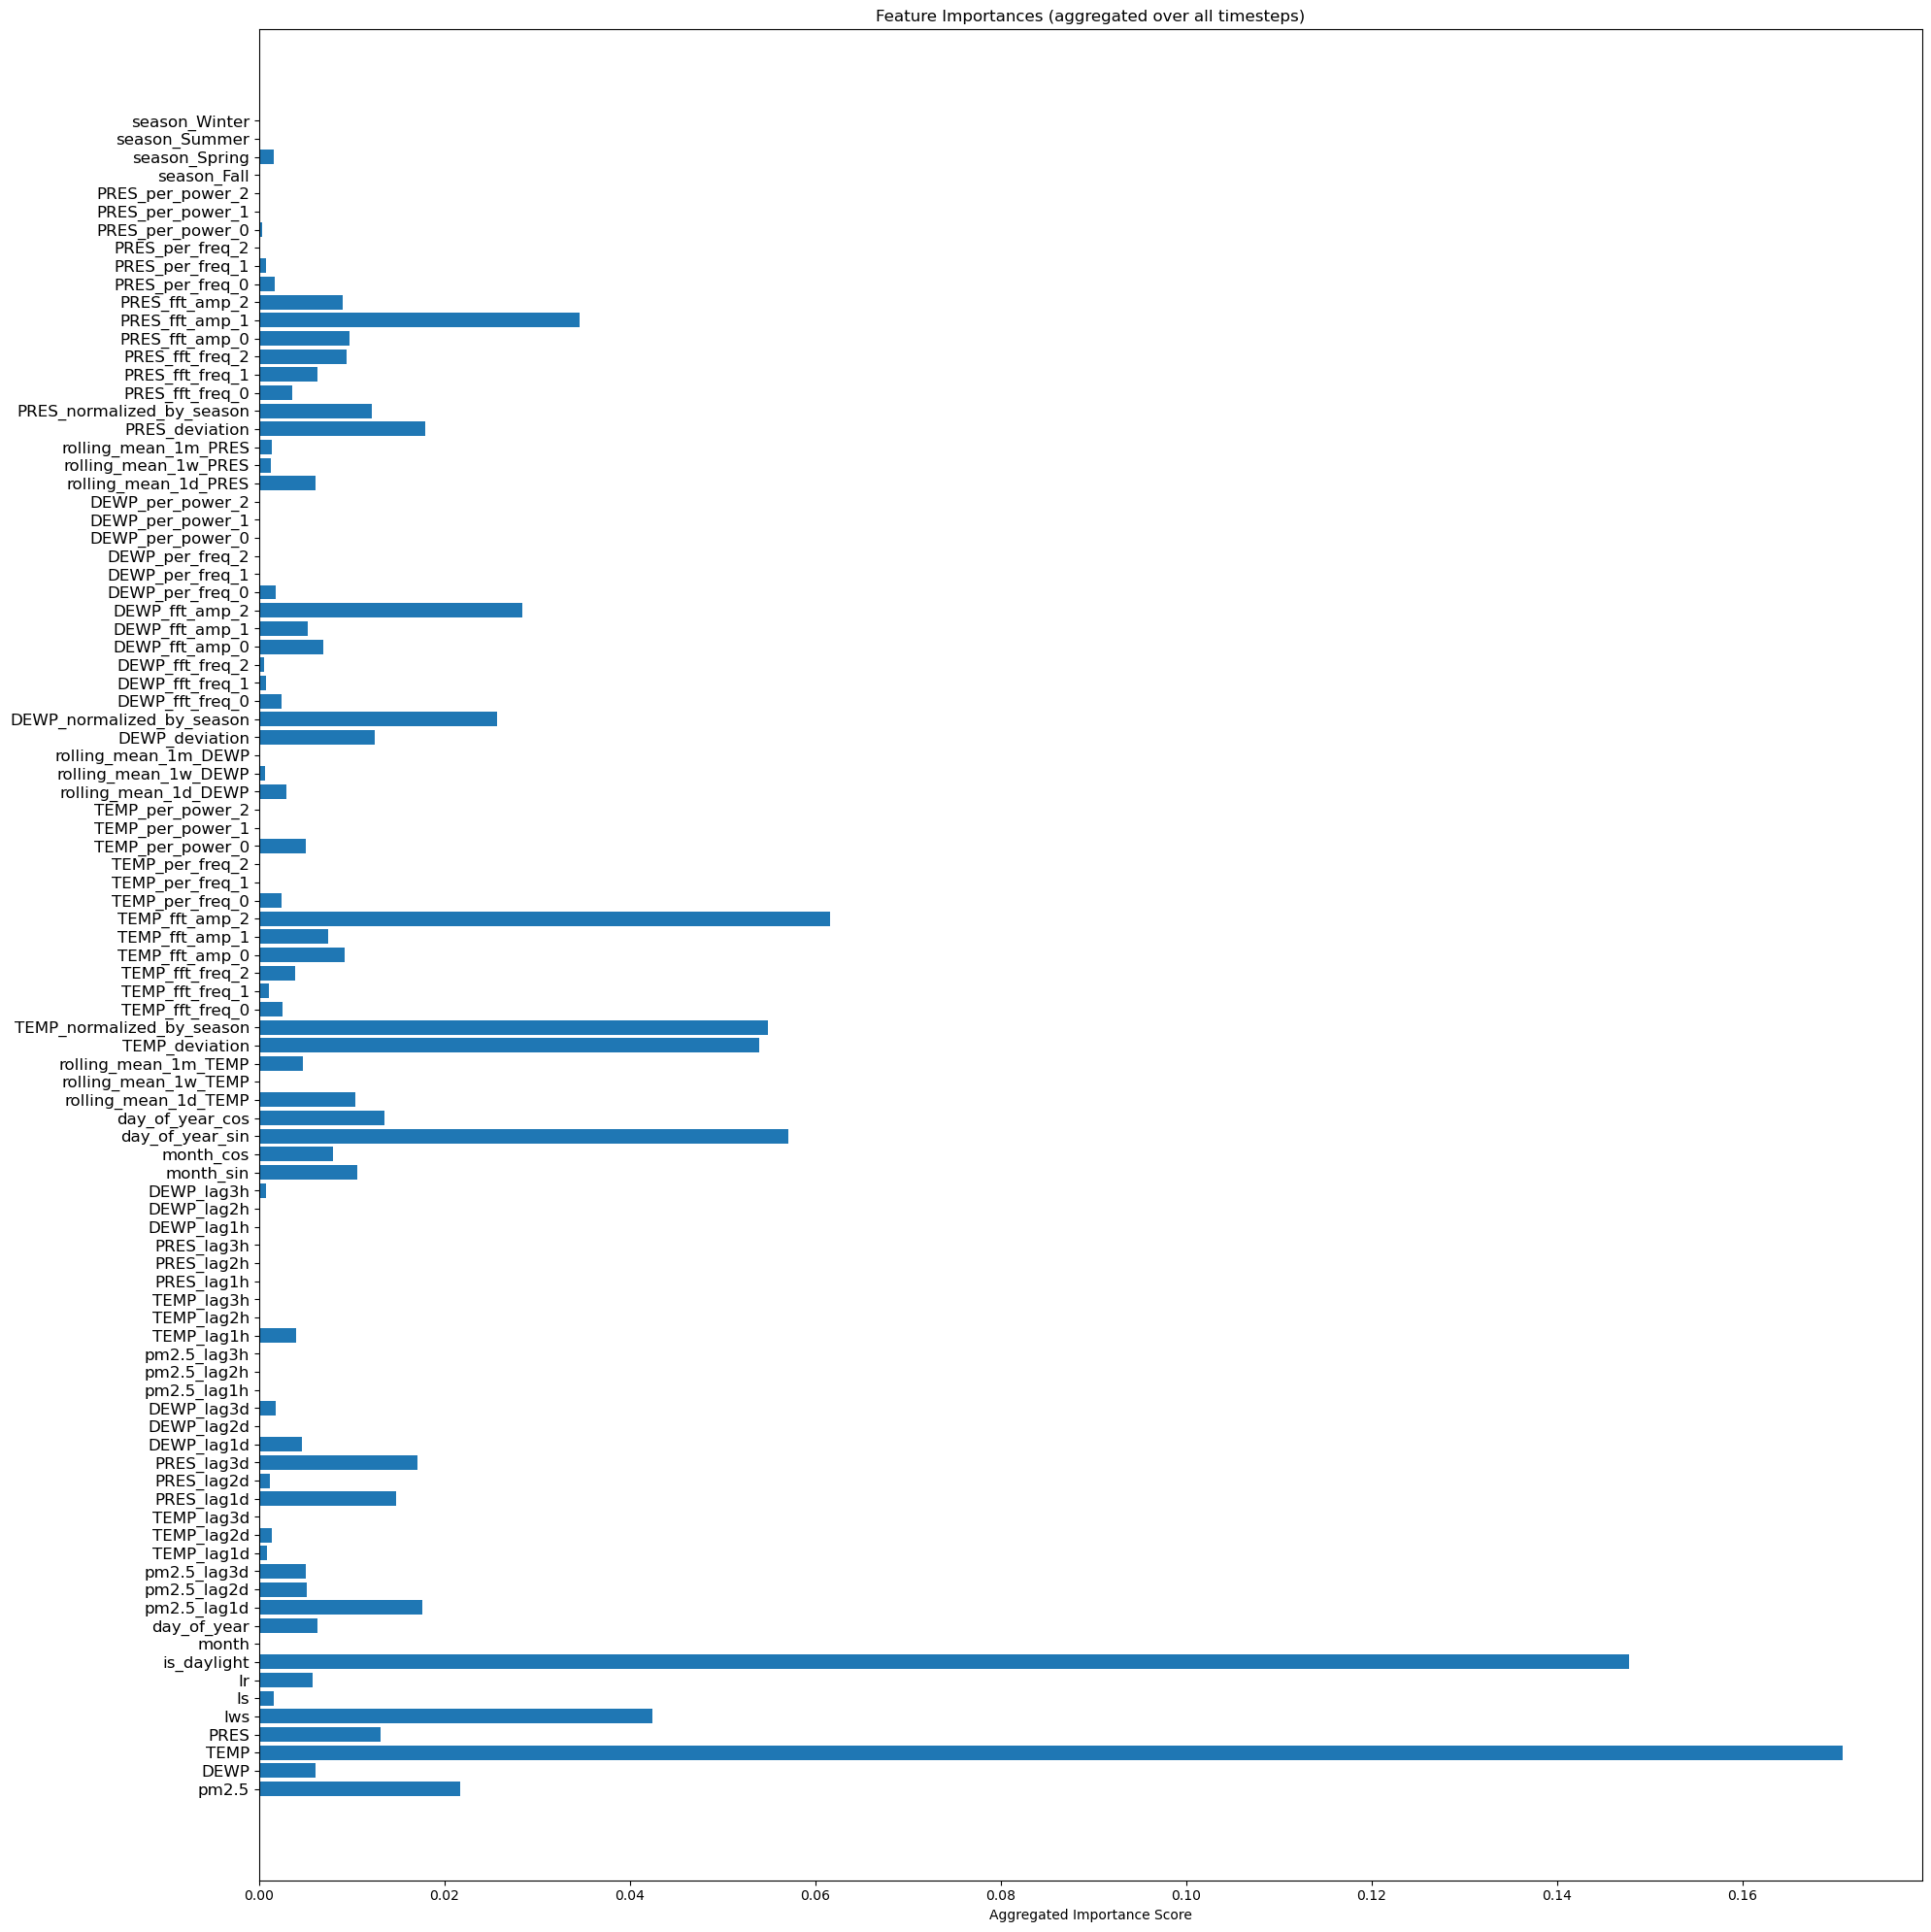

In [44]:
importances = clf.feature_importances_
target_col = 'cbwd'

feature_cols = [c for c in df_rf.columns if c != target_col]
n_feats = len(feature_cols)
timesteps = X_seq.shape[1]

agg_importances = np.zeros(n_feats)
for t in range(timesteps):
    start = t * n_feats
    end   = start + n_feats
    agg_importances += importances[start:end]


plt.figure(figsize=(20, 20))
y_pos = np.arange(len(feature_cols))
plt.barh(y_pos, agg_importances, align='center')
plt.yticks(y_pos, feature_cols, fontsize=12)
plt.xlabel("Aggregated Importance Score")
plt.title("Feature Importances (aggregated over all timesteps)")
plt.tight_layout()
plt.show()

In [45]:
TP, FP, FN, TN = compute_confusion_metrics(cm)

for i, cls in enumerate(le.classes_):
    print(f"\nClass: {cls}")
    print(f"  TP: {TP[i]}")
    print(f"  TN: {TN[i]}")
    print(f"  FP: {FP[i]}")
    print(f"  FN: {FN[i]}")



Class: NE
  TP: 236
  TN: 10643
  FP: 981
  FN: 1266

Class: NW
  TP: 2169
  TN: 8229
  FP: 899
  FN: 1829

Class: SE
  TP: 2821
  TN: 7356
  FP: 1275
  FN: 1674

Class: cv
  TP: 1935
  TN: 7185
  FP: 2810
  FN: 1196


In [196]:
tscv = TimeSeriesSplit(n_splits=5)

y_true_all = []
y_pred_all = []

print("Training with TimeSeriesSplit...")
for train_idx, test_idx in tscv.split(X_flat):
    X_train_fold, X_test_fold = X_flat[train_idx], X_flat[test_idx]
    y_train_fold, y_test_fold = y_seq[train_idx], y_seq[test_idx]

    clf.fit(X_train_fold, y_train_fold)
    y_pred_fold = clf.predict(X_test_fold)

    y_true_all.extend(y_test_fold)
    y_pred_all.extend(y_pred_fold)

print("🔍 Evaluating cross-validation XGBoost")
print(classification_report(y_true_all, y_pred_all))

Training with TimeSeriesSplit...


KeyboardInterrupt: 

X_flat shape: (43752, 6696)
🌲 Training Random Forest model...
🔍 Evaluating...
              precision    recall  f1-score   support

          NE       0.15      0.01      0.02      1502
          NW       0.55      0.69      0.62      3998
          SE       0.60      0.70      0.64      4495
          cv       0.40      0.36      0.38      3131

    accuracy                           0.54     13126
   macro avg       0.43      0.44      0.41     13126
weighted avg       0.49      0.54      0.50     13126

Confusion Matrix:
[[  15  664  424  399]
 [  39 2773  616  570]
 [  22  641 3145  687]
 [  21  924 1074 1112]]


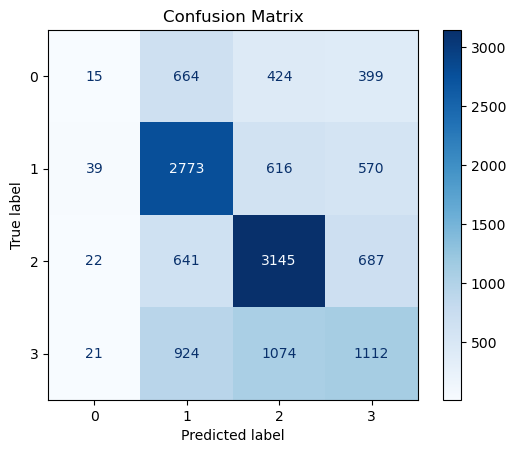

In [46]:
X_flat = X_seq.reshape(X_seq.shape[0], -1)
print(f"X_flat shape: {X_flat.shape}")  # (n_samples, seq_length * features)

split_idx = int(len(X_flat) * (1 - 0.3))
X_train, X_test = X_flat[:split_idx], X_flat[split_idx:]
y_train, y_test = y_seq[:split_idx], y_seq[split_idx:]

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print("🌲 Training Random Forest model...")
clf = RandomForestClassifier(
    n_estimators=70,
    max_depth=15,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced'  
)
clf.fit(X_train, y_train)

print("🔍 Evaluating...")
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=le.classes_))

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_seq))
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()


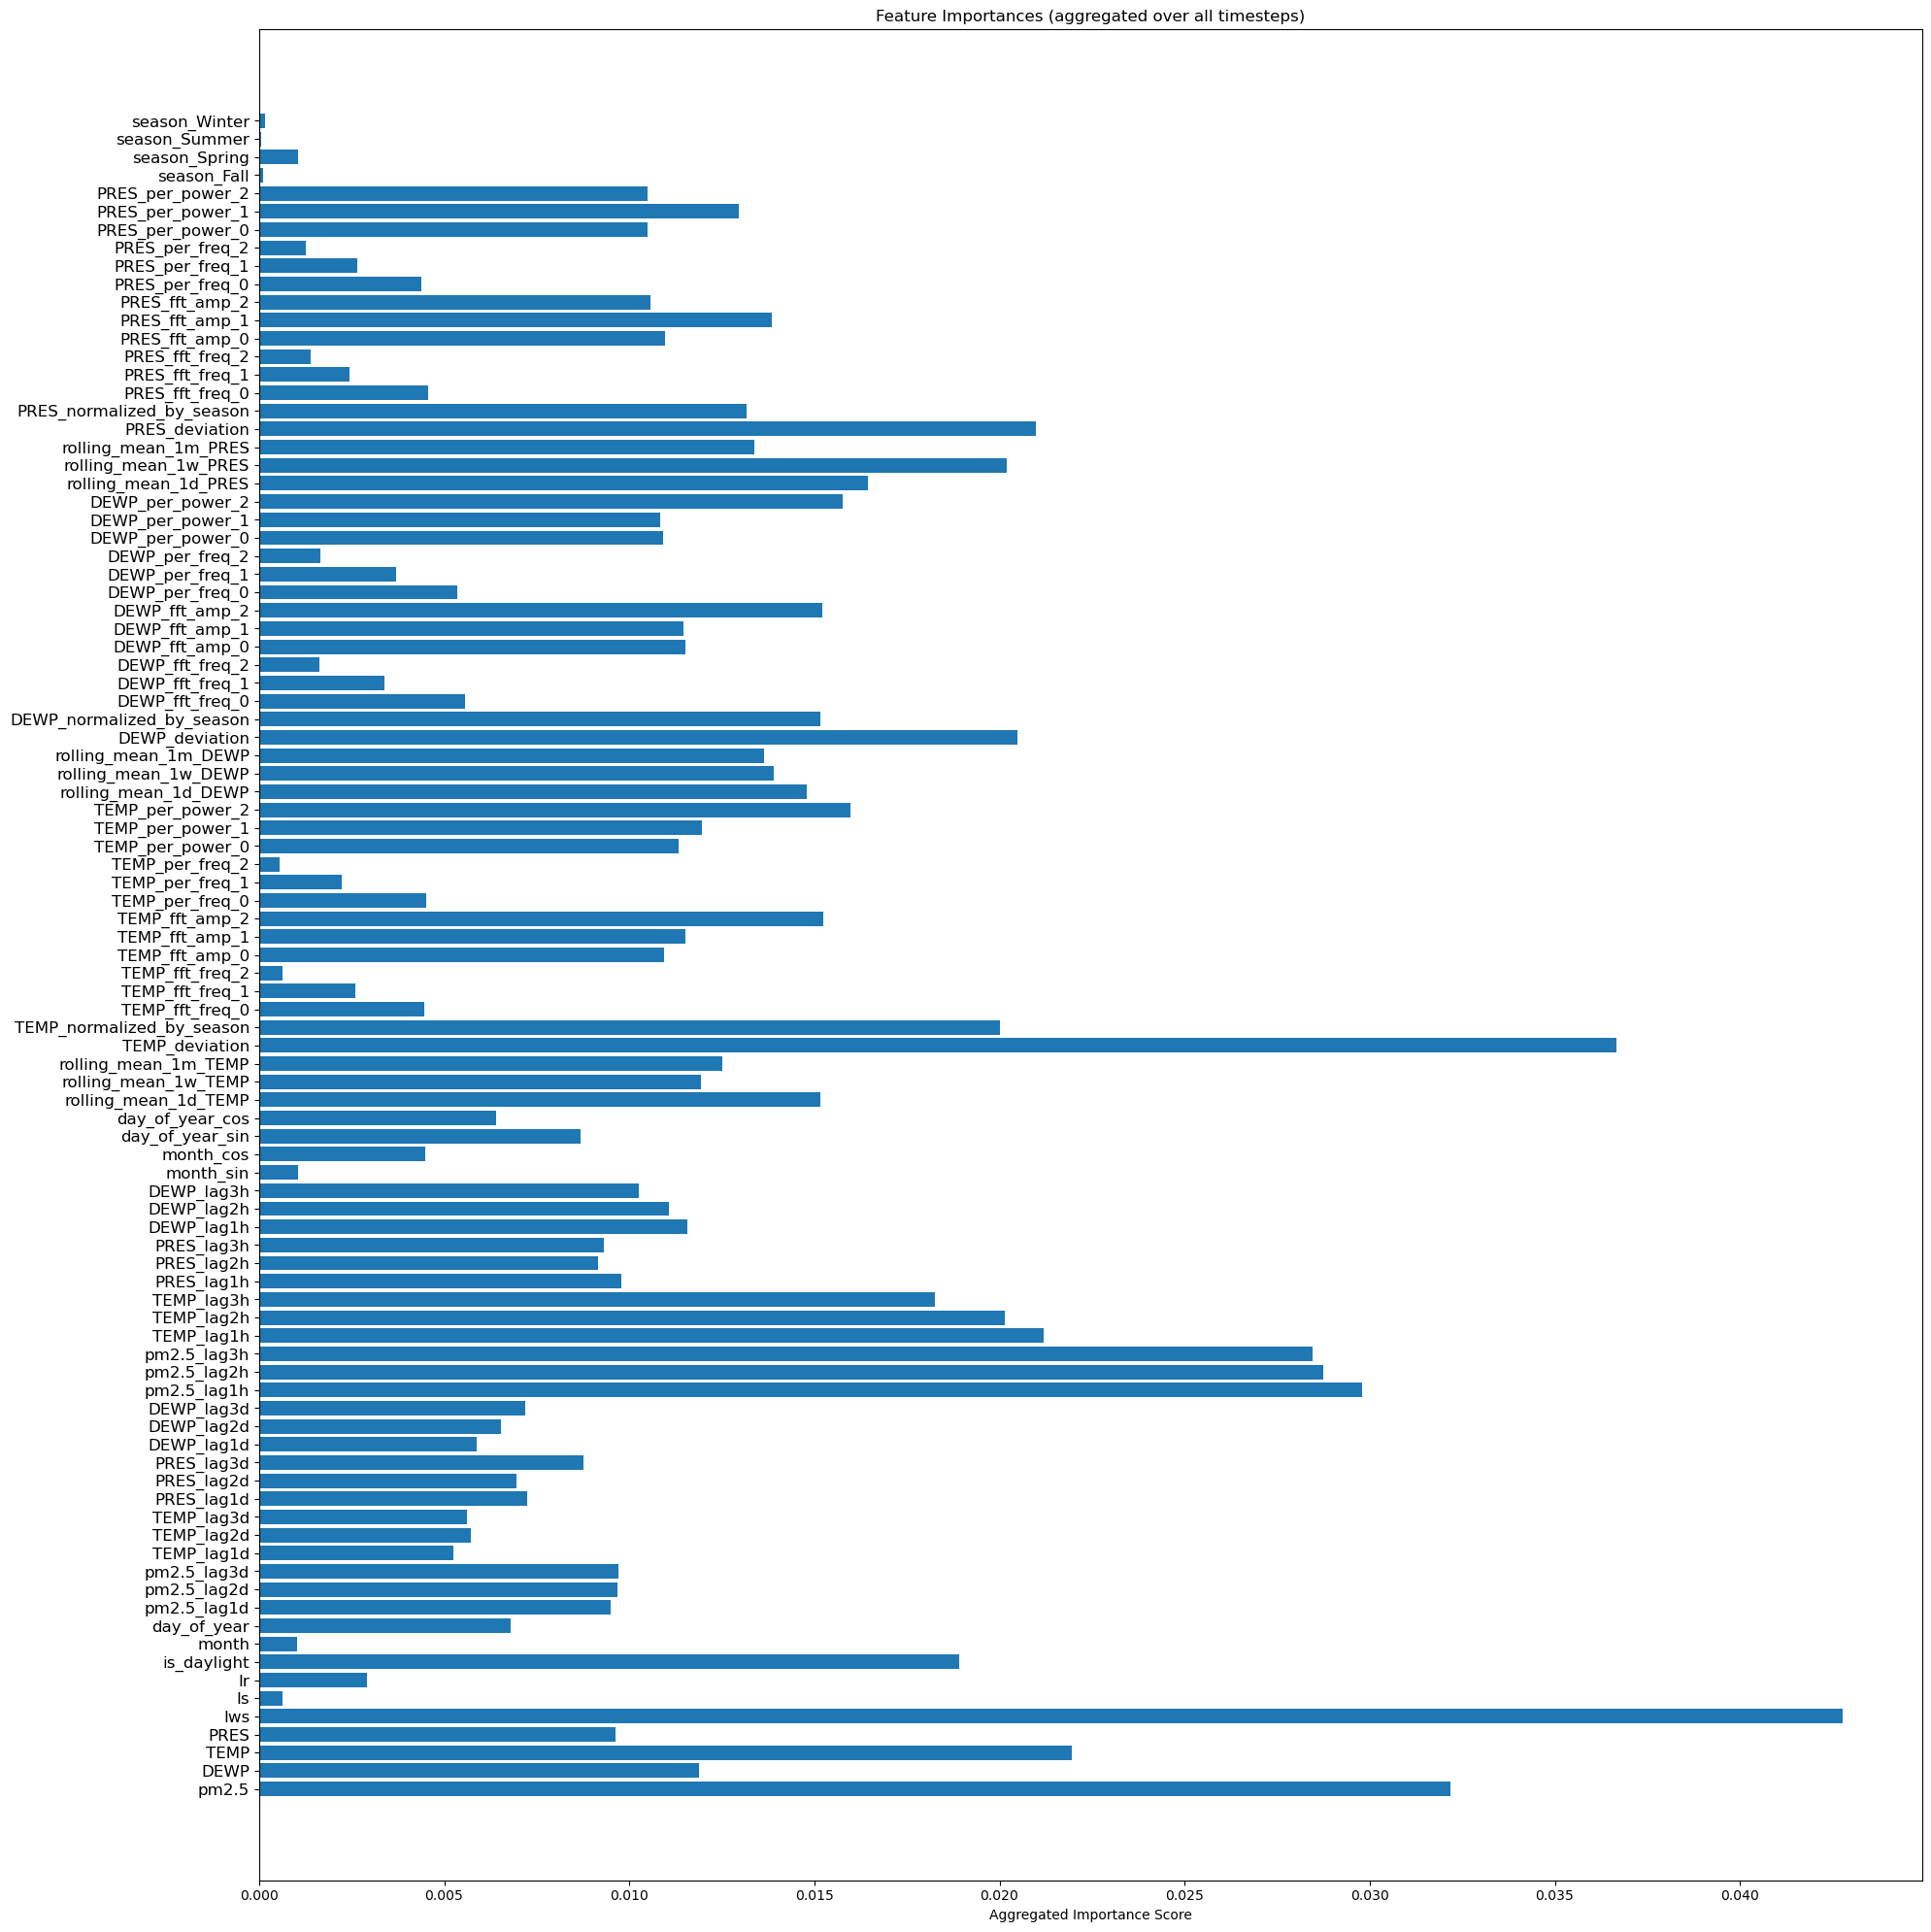

In [47]:

importances = clf.feature_importances_
target_col = 'cbwd'

feature_cols = [c for c in df_rf.columns if c != target_col]
n_feats = len(feature_cols)
timesteps = X_seq.shape[1]

agg_importances = np.zeros(n_feats)
for t in range(timesteps):
    start = t * n_feats
    end   = start + n_feats
    agg_importances += importances[start:end]


plt.figure(figsize=(20, 20))
y_pos = np.arange(len(feature_cols))
plt.barh(y_pos, agg_importances, align='center')
plt.yticks(y_pos, feature_cols, fontsize=12)
plt.xlabel("Aggregated Importance Score")
plt.title("Feature Importances (aggregated over all timesteps)")
plt.tight_layout()
plt.show()

X_seq shape: (43752, 72, 15)
X_flat shape: (43752, 1080)
🌲 Training Random Forest model...
🔍 Evaluating...
              precision    recall  f1-score   support

          NE       0.19      0.02      0.03      1502
          NW       0.59      0.65      0.62      3998
          SE       0.61      0.73      0.66      4495
          cv       0.40      0.41      0.40      3131

    accuracy                           0.55     13126
   macro avg       0.45      0.45      0.43     13126
weighted avg       0.51      0.55      0.52     13126

Confusion Matrix:
[[  24  579  419  480]
 [  40 2594  607  757]
 [  19  509 3294  673]
 [  43  708 1106 1274]]


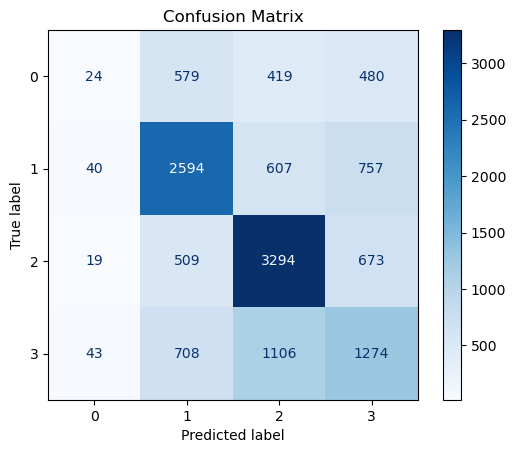

In [54]:

X_seq, y_seq = create_sequences_df(df_rf[top_feature_names], seq_length=72, horizon=1, target_col='cbwd')
print(f"X_seq shape: {X_seq.shape}")  # (n_samples, seq_length, features)

le = LabelEncoder()
y_seq = le.fit_transform(y_seq)
X_flat = X_seq.reshape(X_seq.shape[0], -1)
print(f"X_flat shape: {X_flat.shape}")  # (n_samples, seq_length * features)

split_idx = int(len(X_flat) * (1 - 0.3))
X_train, X_test = X_flat[:split_idx], X_flat[split_idx:]
y_train, y_test = y_seq[:split_idx], y_seq[split_idx:]

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print("🌲 Training Random Forest model...")
clf = RandomForestClassifier(
    n_estimators=70,
    max_depth=15,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced'  
)
clf.fit(X_train, y_train)

print("🔍 Evaluating...")
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=le.classes_))

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_seq))
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()


In [ ]:
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_test, check_additivity=False)
shap.summary_plot(
    shap_values,      
    X_test,
    plot_type="bar",
    feature_names=feature_cols,
    title = f"SHAP Summary Plot for Model",
)

In [347]:
tscv = TimeSeriesSplit(n_splits=5)

y_true_all = []
y_pred_all = []

print("Training with TimeSeriesSplit")
for train_idx, test_idx in tscv.split(X_flat):
    X_train_fold, X_test_fold = X_flat[train_idx], X_flat[test_idx]
    y_train_fold, y_test_fold = y_seq[train_idx], y_seq[test_idx]

    clf.fit(X_train_fold, y_train_fold)
    y_pred_fold = clf.predict(X_test_fold)

    y_true_all.extend(y_test_fold)
    y_pred_all.extend(y_pred_fold)

print("🔍 Evaluating cross-validation Random Forest")
print(classification_report(y_true_all, y_pred_all))

Training with TimeSeriesSplit
🔍 Evaluating cross-validation Random Forest
              precision    recall  f1-score   support

           0       0.16      0.01      0.02      4163
           1       0.54      0.72      0.61     11856
           2       0.58      0.71      0.64     12487
           3       0.37      0.24      0.29      7954

    accuracy                           0.53     36460
   macro avg       0.41      0.42      0.39     36460
weighted avg       0.47      0.53      0.49     36460



In [349]:
X,y = df_rf.iloc[:,:-1],df_rf.iloc[:,-1]

split_idx = int(len(X) * (1 - 0.3))
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print("🌲 Training Random Forest model...")
clf = RandomForestClassifier(
    n_estimators=45,
    max_depth=15,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced',
    criterion='entropy'  
)
clf.fit(X_train, y_train)

print("🔍 Evaluating...")
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=le.classes_))

🌲 Training Random Forest model...
🔍 Evaluating...
              precision    recall  f1-score   support

          NE       0.30      0.07      0.12      1502
          NW       0.67      0.68      0.68      4013
          SE       0.67      0.72      0.70      4502
          cv       0.62      0.78      0.69      3131

    accuracy                           0.65     13148
   macro avg       0.57      0.56      0.55     13148
weighted avg       0.62      0.65      0.62     13148



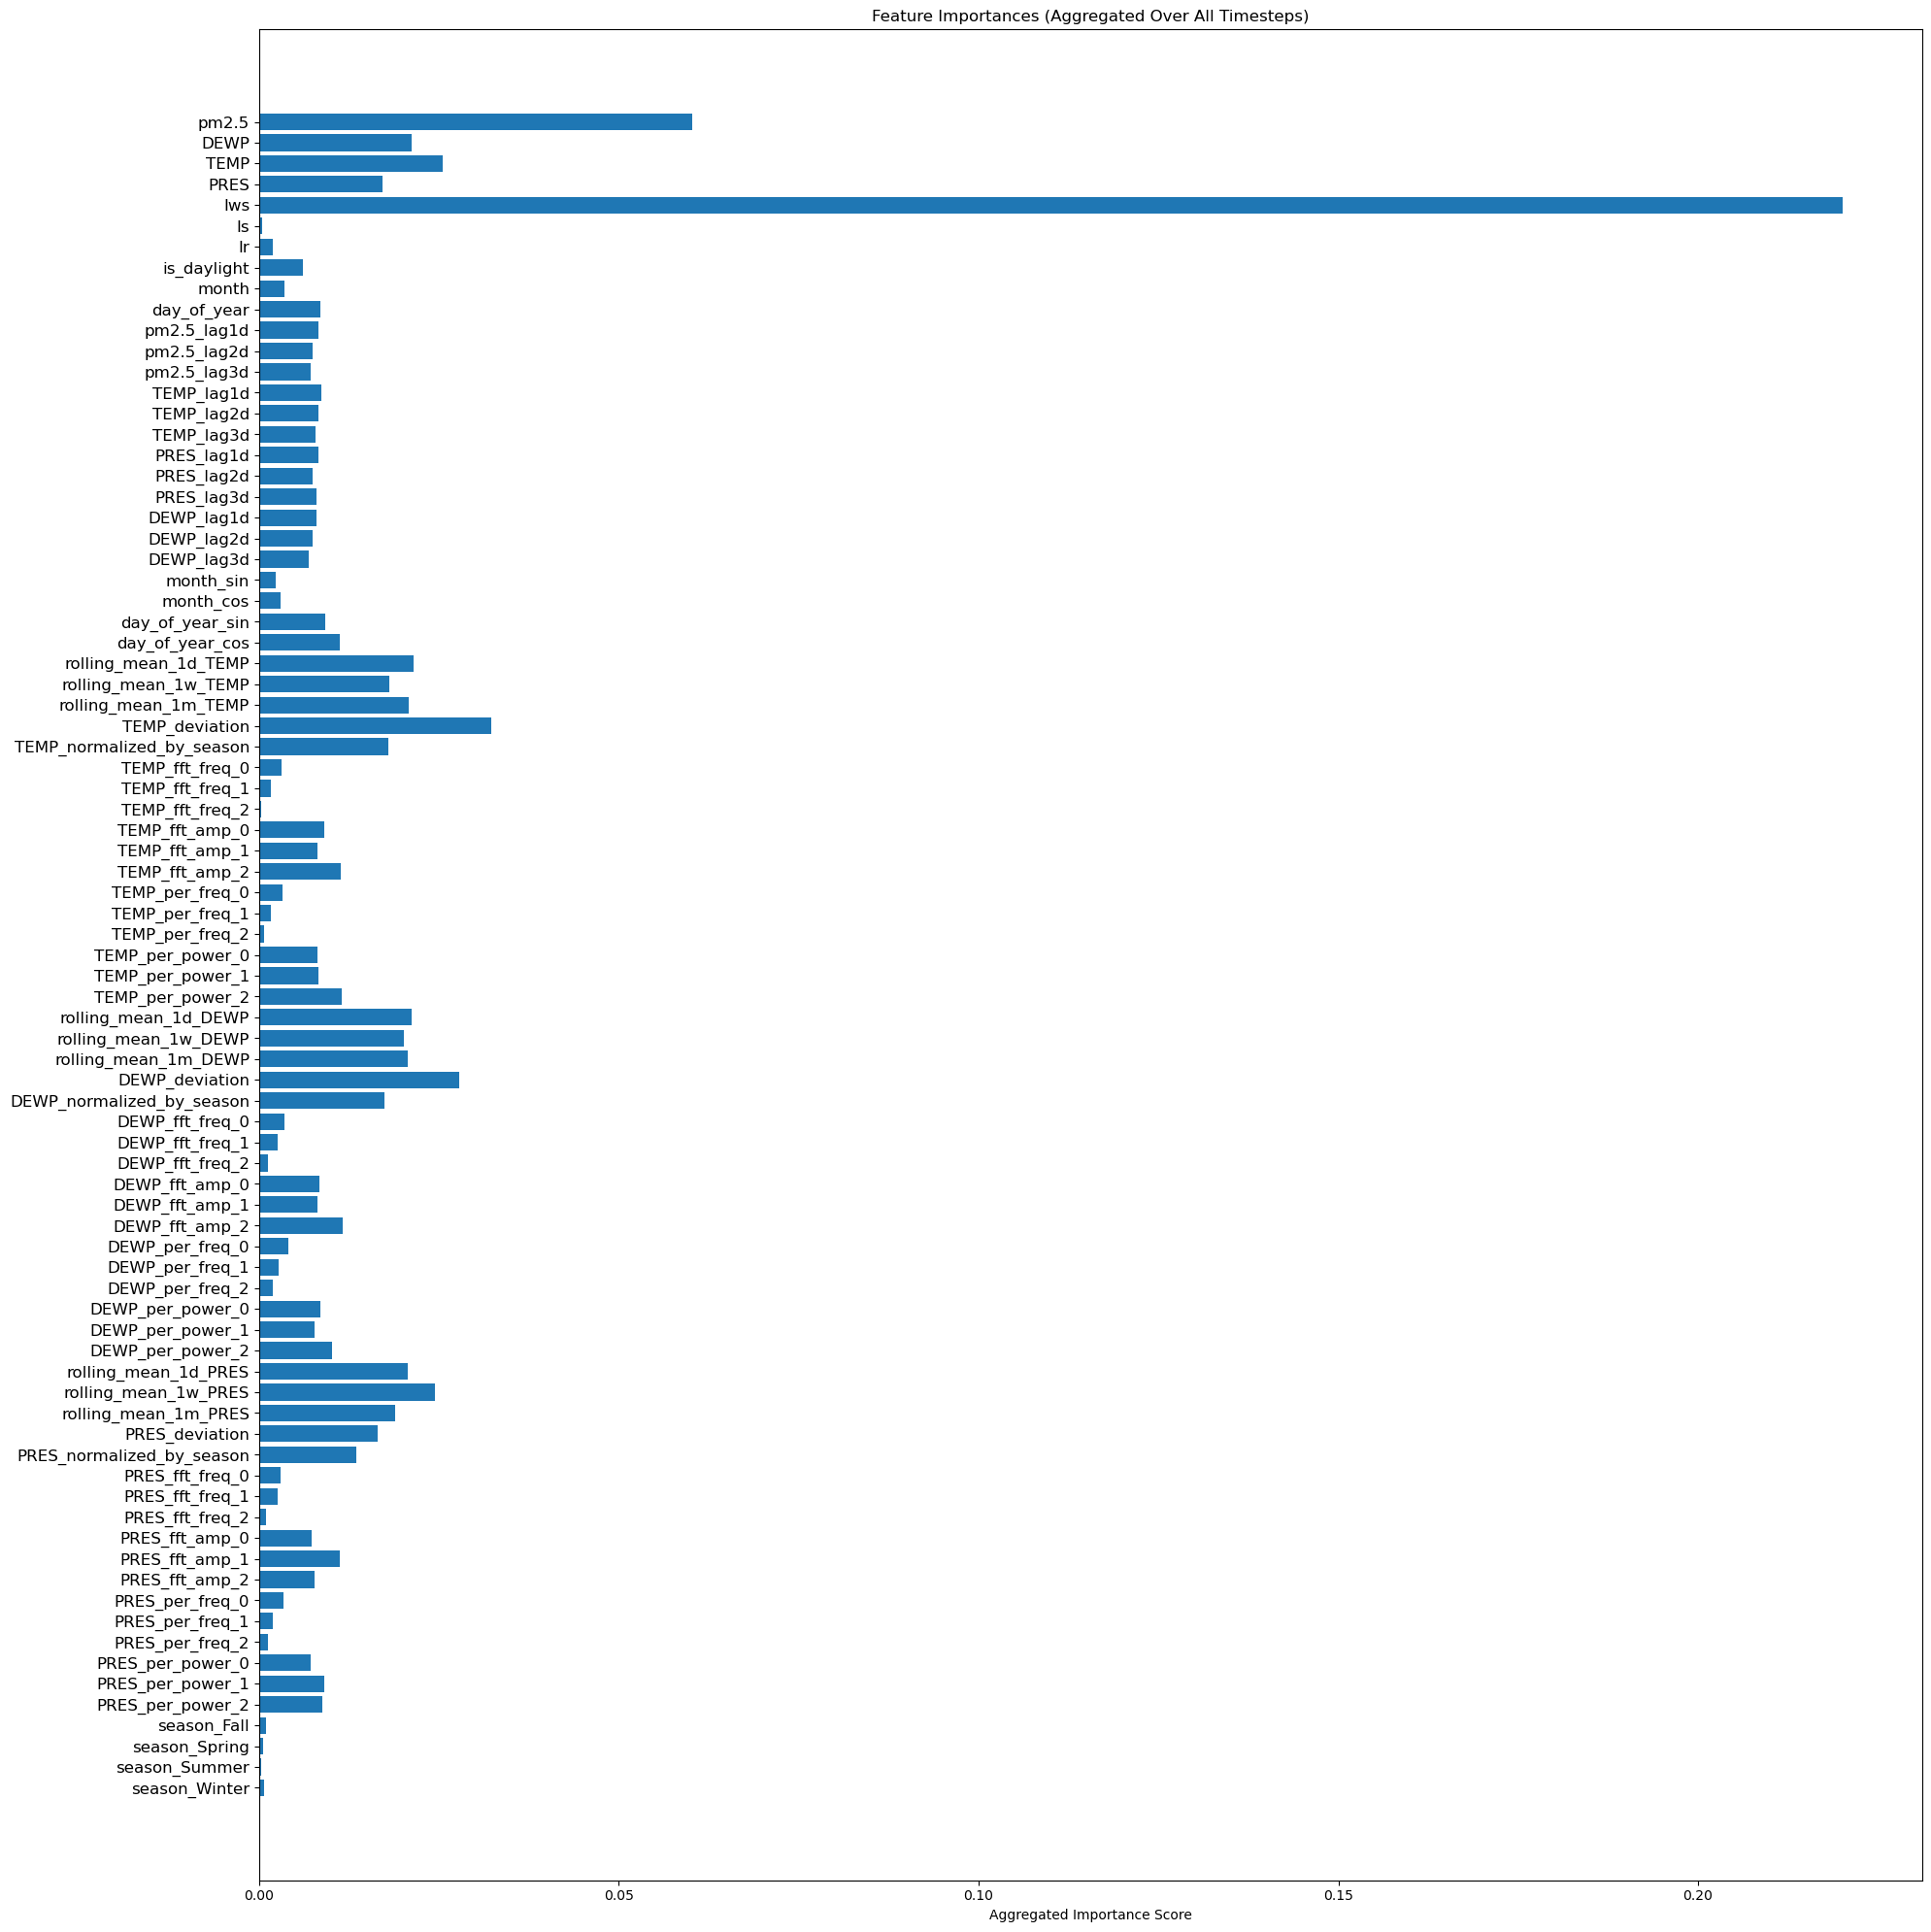

In [ ]:
importances = clf.feature_importances_

target_col = 'cbwd'
feature_cols = [col for col in df_rf.columns if col != target_col]
n_feats = len(feature_cols)
timesteps = X.shape[1] // n_feats  

agg_importances = np.zeros(n_feats)
for t in range(timesteps):
    start = t * n_feats
    end = start + n_feats
    agg_importances += importances[start:end]

plt.figure(figsize=(20, 20))
y_pos = np.arange(n_feats)
plt.barh(y_pos, agg_importances, align='center')
plt.yticks(y_pos, feature_cols, fontsize=12)
plt.xlabel("Aggregated Importance Score")
plt.title("Feature Importances (Aggregated Over All Timesteps)")
plt.gca().invert_yaxis()  
plt.tight_layout()
plt.show()

In [324]:
df.columns

Index(['pm2.5', 'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'is_daylight',
       'cbwd_NE', 'cbwd_NW', 'cbwd_SE', 'cbwd_cv', 'month', 'day_of_year',
       'pm2.5_lag1d', 'pm2.5_lag2d', 'pm2.5_lag3d', 'TEMP_lag1d', 'TEMP_lag2d',
       'TEMP_lag3d', 'PRES_lag1d', 'PRES_lag2d', 'PRES_lag3d', 'DEWP_lag1d',
       'DEWP_lag2d', 'DEWP_lag3d', 'month_sin', 'month_cos', 'day_of_year_sin',
       'day_of_year_cos', 'rolling_mean_1d_TEMP', 'rolling_mean_1w_TEMP',
       'rolling_mean_1m_TEMP', 'TEMP_deviation', 'TEMP_normalized_by_season',
       'TEMP_fft_freq_0', 'TEMP_fft_freq_1', 'TEMP_fft_freq_2',
       'TEMP_fft_amp_0', 'TEMP_fft_amp_1', 'TEMP_fft_amp_2', 'TEMP_per_freq_0',
       'TEMP_per_freq_1', 'TEMP_per_freq_2', 'TEMP_per_power_0',
       'TEMP_per_power_1', 'TEMP_per_power_2', 'rolling_mean_1d_DEWP',
       'rolling_mean_1w_DEWP', 'rolling_mean_1m_DEWP', 'DEWP_deviation',
       'DEWP_normalized_by_season', 'DEWP_fft_freq_0', 'DEWP_fft_freq_1',
       'DEWP_fft_freq_2', 'DEWP_fft

In [325]:
len(y_train)

30676

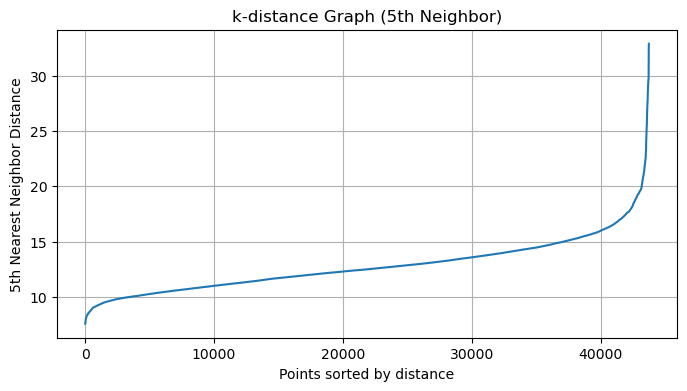

In [60]:
scaler = StandardScaler()
X_flat_scaled = scaler.fit_transform(X_flat)
neighbors = NearestNeighbors(n_neighbors=5)  
neighbors_fit = neighbors.fit(X_flat_scaled)
distances, indices = neighbors_fit.kneighbors(X_flat_scaled)

distances = np.sort(distances[:, 4])  
plt.figure(figsize=(8, 4))
plt.plot(distances)
plt.title("k-distance Graph (5th Neighbor)")
plt.xlabel("Points sorted by distance")
plt.ylabel("5th Nearest Neighbor Distance")
plt.grid()
plt.show()

In [403]:
weighted_importance

season_Winter                0.093669
TEMP_fft_amp_1               0.090735
TEMP_per_power_1             0.090572
PRES_normalized_by_season    0.089195
TEMP_fft_amp_0               0.089133
                               ...   
DEWP_per_freq_0              0.057322
Ir                           0.055838
DEWP_fft_freq_0              0.055260
Is                           0.044108
cbwd_NE                      0.042839
Length: 85, dtype: float64

X_seq shape: (43752, 72, 15)
X_flat shape: (43752, 1080)
Number of clusters found: 5
Number of noise points: 1267
Silhouette Score: 0.040991258261334894
Calinski-Harabasz Score: 173.41791901629378
Davies-Bouldin Score: 2.722376897177822


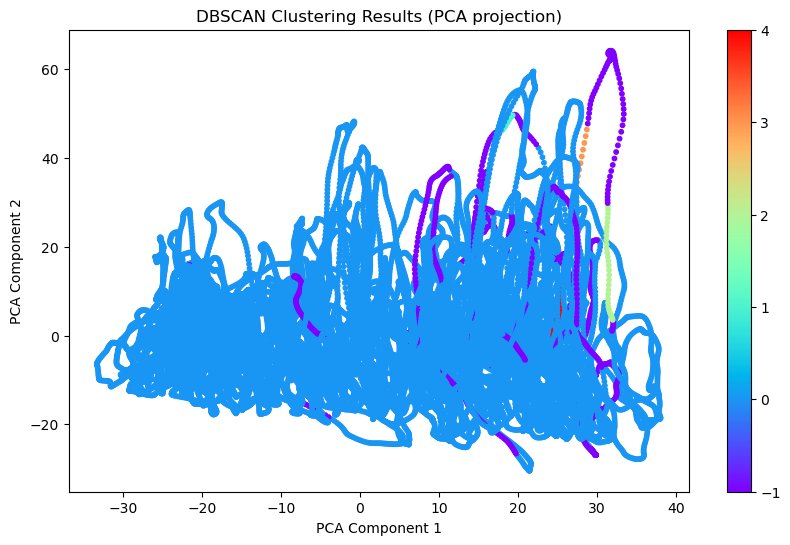

In [63]:
X_seq, y_seq = create_sequences_df(df_rf[top_feature_names], seq_length=72, horizon=1, target_col='cbwd')
print(f"X_seq shape: {X_seq.shape}")

X_flat = X_seq.reshape(X_seq.shape[0], -1)
print(f"X_flat shape: {X_flat.shape}")

scaler = StandardScaler()
X_flat_scaled = scaler.fit_transform(X_flat)

dbscan = DBSCAN(eps=18, min_samples=5, n_jobs=-1) 
clusters = dbscan.fit_predict(X_flat_scaled)

num_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)  # Excluding noise (-1)
num_noise = np.sum(clusters == -1)
print(f"Number of clusters found: {num_clusters}")
print(f"Number of noise points: {num_noise}")


if num_clusters > 1: 
    silhouette = silhouette_score(X_flat_scaled, clusters)
    calinski_harabasz = calinski_harabasz_score(X_flat_scaled, clusters)
    davies_bouldin = davies_bouldin_score(X_flat_scaled, clusters)

    print(f"Silhouette Score: {silhouette}")
    print(f"Calinski-Harabasz Score: {calinski_harabasz}")
    print(f"Davies-Bouldin Score: {davies_bouldin}")
else:
    print("Clustering has less than 2 clusters. Cannot compute clustering evaluation metrics.")


pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_flat_scaled)


plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='rainbow', s=10)
plt.title("DBSCAN Clustering Results (PCA projection)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(scatter)
plt.show()

X_seq shape: (43752, 72, 15)
X_flat shape: (43752, 1080)
Silhouette Score: 0.22810602095835195
Calinski-Harabasz Score: 10307.2425821014
Davies-Bouldin Score: 1.9328265669568456


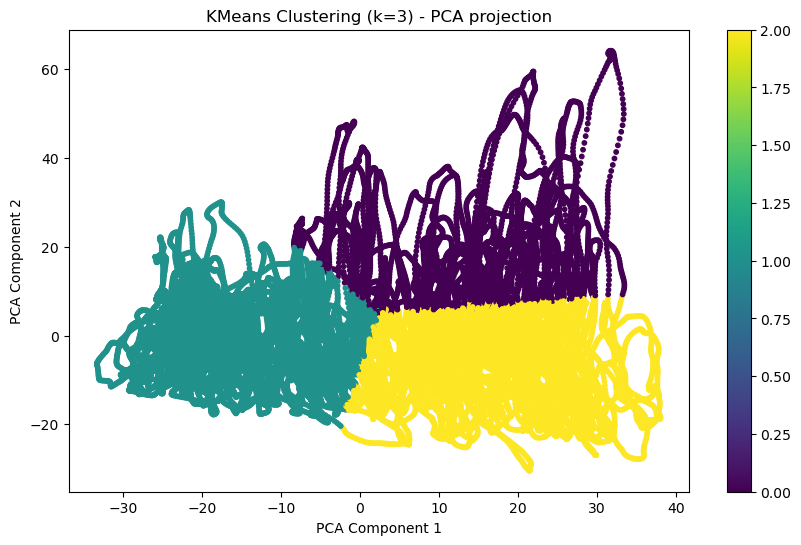

In [68]:
X_seq, y_seq = create_sequences_df(df_rf[top_feature_names], seq_length=72, horizon=1, target_col='cbwd')
print(f"X_seq shape: {X_seq.shape}")

X_flat = X_seq.reshape(X_seq.shape[0], -1)
print(f"X_flat shape: {X_flat.shape}")

scaler = StandardScaler()
X_flat_scaled = scaler.fit_transform(X_flat)

n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init="auto")
clusters = kmeans.fit_predict(X_flat_scaled)

silhouette = silhouette_score(X_flat_scaled, clusters)
calinski_harabasz = calinski_harabasz_score(X_flat_scaled, clusters)
davies_bouldin = davies_bouldin_score(X_flat_scaled, clusters)

print(f"Silhouette Score: {silhouette}")
print(f"Calinski-Harabasz Score: {calinski_harabasz}")
print(f"Davies-Bouldin Score: {davies_bouldin}")

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_flat_scaled)

plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis', s=10)
plt.title(f"KMeans Clustering (k={n_clusters}) - PCA projection")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(scatter)
plt.show()

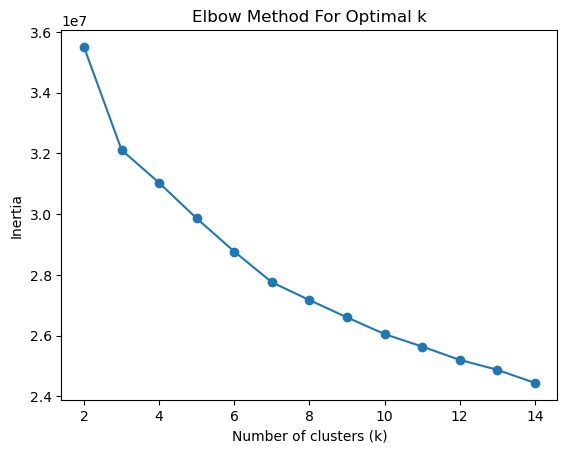

In [65]:
inertia = []
k_range = range(2, 15)

for k in k_range:
    km = KMeans(n_clusters=k, random_state=42, n_init="auto")
    km.fit(X_flat_scaled)
    inertia.append(km.inertia_)

plt.plot(k_range, inertia, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.show()

In [92]:
def create_forecasting_sequences(df, seq_length, target_col):
    xs, ys = [], []
    feature_cols = [col for col in df.columns if col != target_col]
    data = df[feature_cols].values
    target = df[target_col].values

    for i in range(len(data) - seq_length):
        x = data[i:i + seq_length]
        y = target[i + seq_length]
        xs.append(x)
        ys.append(y)

    return np.array(xs), np.array(ys)

Training RandomForest model...
Training XGBoost model...
RandomForest on last 720 days → RMSE: 3.183,  MAE: 2.558 , MSE: 10.133
XGBoost on last 720 days → RMSE: 2.593,  MAE: 2.026 , MSE: 6.726


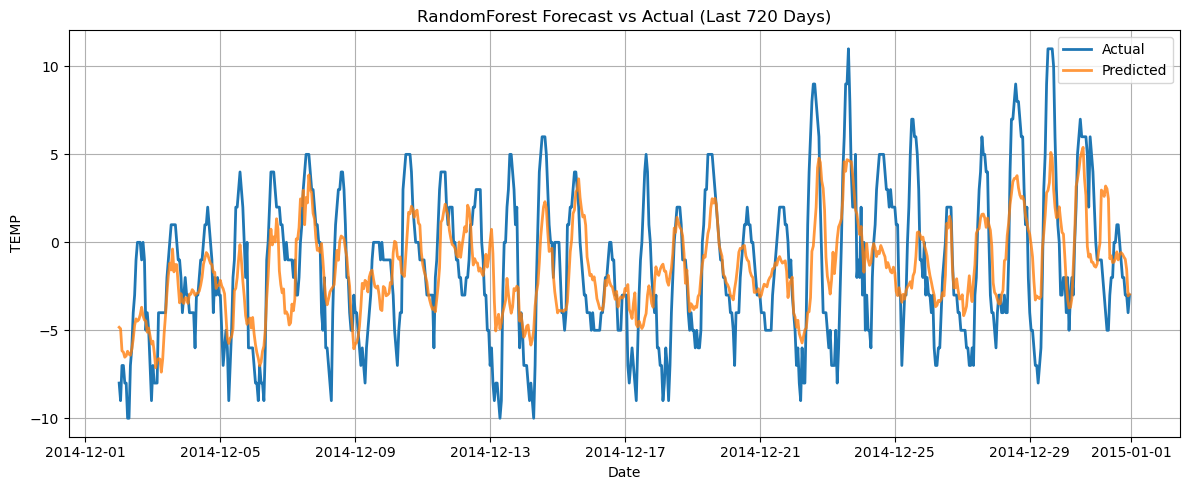

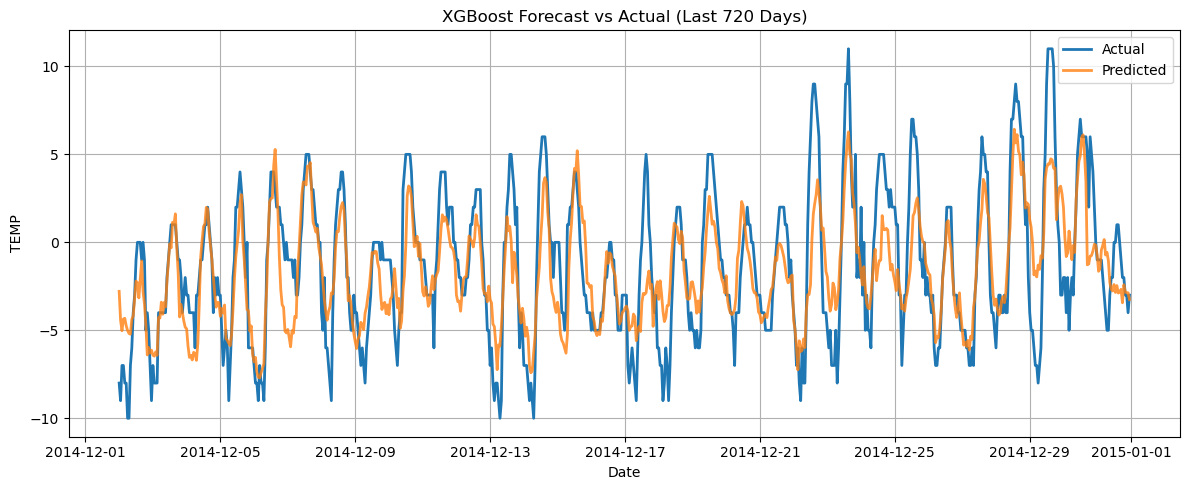

In [ ]:
seq_length = 72
target_col = 'TEMP'

X_seq, y_seq = create_forecasting_sequences(df, seq_length, target_col)
all_dates = df.index[seq_length:]

X_flat = X_seq.reshape(X_seq.shape[0], -1)
scaler = StandardScaler()
X_flat_scaled = scaler.fit_transform(X_flat)

test_size = 720
train_end = len(X_flat_scaled) - test_size

X_train, X_test = X_flat_scaled[:train_end], X_flat_scaled[train_end:]
y_train, y_test = y_seq[:train_end], y_seq[train_end:]
dates_test = all_dates[-test_size:]  


models = {
    "RandomForest": RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    "XGBoost":      XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42, n_jobs=-1),
    # "SVR":          SVR(kernel='rbf', C=1.0, epsilon=0.1)
}

results = {}
for name, model in models.items():
    
    print(f"Training {name} model...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae  = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)

    results[name] = {
        "RMSE":    rmse,
        "MAE":     mae,
        "MSE":     mse,
        "y_true":  y_test,
        "y_pred":  y_pred
    }


for name, m in results.items():
    print(f"{name} on last {test_size} days → RMSE: {m['RMSE']:.3f},  MAE: {m['MAE']:.3f} , MSE: {m['MSE']:.3f}")

for name, m in results.items():
    plt.figure(figsize=(12, 5))
    plt.plot(dates_test, m['y_true'], label="Actual", linewidth=2)
    plt.plot(dates_test, m['y_pred'], label="Predicted", linewidth=2, alpha=0.8)
    plt.title(f"{name} Forecast vs Actual (Last {test_size/24} days)")
    plt.xlabel("Date")
    plt.ylabel(target_col)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [191]:
df_new = pd.read_csv("BEIJING.csv")

In [192]:
df_new 

No  year  month  day  hour  pm2.5  DEWP  TEMP    PRES cbwd     Iws  \
0          1  2010      1    1     0    NaN   -21 -11.0  1021.0   NW    1.79   
1          2  2010      1    1     1    NaN   -21 -12.0  1020.0   NW    4.92   
2          3  2010      1    1     2    NaN   -21 -11.0  1019.0   NW    6.71   
3          4  2010      1    1     3    NaN   -21 -14.0  1019.0   NW    9.84   
4          5  2010      1    1     4    NaN   -20 -12.0  1018.0   NW   12.97   
...      ...   ...    ...  ...   ...    ...   ...   ...     ...  ...     ...   
43819  43820  2014     12   31    19    8.0   -23  -2.0  1034.0   NW  231.97   
43820  43821  2014     12   31    20   10.0   -22  -3.0  1034.0   NW  237.78   
43821  43822  2014     12   31    21   10.0   -22  -3.0  1034.0   NW  242.70   
43822  43823  2014     12   31    22    8.0   -22  -4.0  1034.0   NW  246.72   
43823  43824  2014     12   31    23   12.0   -21  -3.0  1034.0   NW  249.85   

       Is  Ir  
0       0   0  
1       0   0  
2       0   0  
3       0   0  
4       0   0  
...    ..  ..  
43819   0   0  
43820   0   0  
43821   0   0  
43822   0   0  
43823   0   0  

[43824 rows x 13 columns]

In [193]:
categorical_cols = ['cbwd']
encoder = OneHotEncoder(sparse=False, drop=None)
encoded_array = encoder.fit_transform(df_new[categorical_cols])
encoded_col_names = encoder.get_feature_names_out(categorical_cols)
encoded_df = pd.DataFrame(encoded_array, columns=encoded_col_names, index=df_new.index)
df_new = pd.concat([df_new.drop(columns=categorical_cols), encoded_df], axis=1)

/Users/iuliuandreisteau/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [194]:
target_col = 'pm2.5'
feature_cols = [col for col in df_new.columns if col != target_col]
impute_df = df_new[[target_col] + feature_cols]
imputer = KNNImputer(n_neighbors=5)
imputed_array = imputer.fit_transform(impute_df)
df_new[target_col] = imputed_array[:, 0]

In [195]:
df_new

No  year  month  day  hour  pm2.5  DEWP  TEMP    PRES     Iws  Is  \
0          1  2010      1    1     0  151.0   -21 -11.0  1021.0    1.79   0   
1          2  2010      1    1     1  151.0   -21 -12.0  1020.0    4.92   0   
2          3  2010      1    1     2  151.0   -21 -11.0  1019.0    6.71   0   
3          4  2010      1    1     3  151.0   -21 -14.0  1019.0    9.84   0   
4          5  2010      1    1     4  151.0   -20 -12.0  1018.0   12.97   0   
...      ...   ...    ...  ...   ...    ...   ...   ...     ...     ...  ..   
43819  43820  2014     12   31    19    8.0   -23  -2.0  1034.0  231.97   0   
43820  43821  2014     12   31    20   10.0   -22  -3.0  1034.0  237.78   0   
43821  43822  2014     12   31    21   10.0   -22  -3.0  1034.0  242.70   0   
43822  43823  2014     12   31    22    8.0   -22  -4.0  1034.0  246.72   0   
43823  43824  2014     12   31    23   12.0   -21  -3.0  1034.0  249.85   0   

       Ir  cbwd_NE  cbwd_NW  cbwd_SE  cbwd_cv  
0       0      0.0      1.0      0.0      0.0  
1       0      0.0      1.0      0.0      0.0  
2       0      0.0      1.0      0.0      0.0  
3       0      0.0      1.0      0.0      0.0  
4       0      0.0      1.0      0.0      0.0  
...    ..      ...      ...      ...      ...  
43819   0      0.0      1.0      0.0      0.0  
43820   0      0.0      1.0      0.0      0.0  
43821   0      0.0      1.0      0.0      0.0  
43822   0      0.0      1.0      0.0      0.0  
43823   0      0.0      1.0      0.0      0.0  

[43824 rows x 16 columns]

In [196]:
cbwd_columns = [col for col in df_new.columns if col.startswith("cbwd_")]
df_new['cbwd'] = df_new[cbwd_columns].idxmax(axis=1).str.replace('cbwd_', '')
df_new= df_new.drop(columns=[col for col in df_new.columns if col.startswith("cbwd_")])

In [197]:
agg_funcs = {
    'pm2.5': 'mean',
    'DEWP': 'mean',
    'TEMP': 'mean',
    'PRES': 'mean',
    'Iws': 'mean',
    'Is': 'mean',
    'Ir': 'mean',
    'cbwd': lambda x: x.mode()[0]  
}

df_new = df_new.groupby(['year', 'month', 'day']).agg(agg_funcs).reset_index()

In [198]:
df_new["year"] = df_new["year"].astype(str)
df_new["month"] = df_new["month"].astype(str)
df_new["day"] = df_new["day"].astype(str)
df_new['date'] = pd.to_datetime(df_new[['year', 'month', 'day']])
df_new = df_new.set_index('date')
df_new = df_new.drop(columns=["year", "month", "day"])

In [199]:
df_new

pm2.5       DEWP       TEMP         PRES         Iws  \
date                                                                    
2010-01-01  148.450000 -18.750000  -6.750000  1017.083333   14.458333   
2010-01-02  145.958333  -8.500000  -5.125000  1024.750000   24.860000   
2010-01-03   78.833333 -10.125000  -8.541667  1022.791667   70.937917   
2010-01-04   31.333333 -20.875000 -11.500000  1029.291667  111.160833   
2010-01-05   42.458333 -24.583333 -14.458333  1033.625000   56.920000   
...                ...        ...        ...          ...         ...   
2014-12-27  238.666667  -9.666667  -1.791667  1027.833333    9.278333   
2014-12-28  197.375000 -10.791667   1.583333  1019.958333   10.948750   
2014-12-29  159.000000 -12.333333   0.750000  1013.750000    8.000000   
2014-12-30   46.083333 -13.916667   1.875000  1019.125000    9.778333   
2014-12-31   10.041667 -21.791667  -1.916667  1032.125000  167.458333   

                   Is   Ir cbwd  
date                             
2010-01-01   0.000000  0.0   NW  
2010-01-02   0.708333  0.0   SE  
2010-01-03  14.166667  0.0   SE  
2010-01-04   0.000000  0.0   NW  
2010-01-05   0.000000  0.0   NW  
...               ...  ...  ...  
2014-12-27   0.000000  0.0   NW  
2014-12-28   0.000000  0.0   NW  
2014-12-29   0.000000  0.0   cv  
2014-12-30   0.000000  0.0   NW  
2014-12-31   0.000000  0.0   NW  

[1826 rows x 8 columns]

In [200]:
def add_features_new(df, col):
    df['month'] = df.index.month
    df['day_of_year'] = df.index.dayofyear
    df['season'] = pd.cut(df['day_of_year'], 
                        bins=[0, 59, 151, 242, 333,366], 
                        labels=['Winter', 'Spring', 'Summer', 'Fall','Winter'],ordered=False)

    df['month_sin'] = np.sin(2 * np.pi * df['month']/12)
    df['month_cos'] = np.cos(2 * np.pi * df['month']/12)
    df['day_of_year_sin'] = np.sin(2 * np.pi * df['day_of_year']/365.25)
    df['day_of_year_cos'] = np.cos(2 * np.pi * df['day_of_year']/365.25)
    
    df['rolling_mean_1w'+'_'+ col] = df[col].rolling(window=7,min_periods = 1).mean()
    daily_avg = df.groupby(df.index.dayofyear)[col].transform('mean')
    df['temp_deviation'] = df[col] - daily_avg
    seasonal_min = df.groupby('season')[col].transform('min')
    seasonal_max = df.groupby('season')[col].transform('max')
    df['temp_normalized_by_season'] = (df[col] - seasonal_min) / (seasonal_max - seasonal_min)
    spectral_features = add_spectral_features(df[col])
    for coli in spectral_features.index:
        df[coli] = spectral_features[coli]
    
    return df

In [201]:
df_new = add_features_new(df_new, "TEMP")
df_new = add_features_new(df_new, "DEWP")
df_new = add_features_new(df_new, "PRES")

In [202]:
df_new

pm2.5       DEWP       TEMP         PRES         Iws  \
date                                                                    
2010-01-01  148.450000 -18.750000  -6.750000  1017.083333   14.458333   
2010-01-02  145.958333  -8.500000  -5.125000  1024.750000   24.860000   
2010-01-03   78.833333 -10.125000  -8.541667  1022.791667   70.937917   
2010-01-04   31.333333 -20.875000 -11.500000  1029.291667  111.160833   
2010-01-05   42.458333 -24.583333 -14.458333  1033.625000   56.920000   
...                ...        ...        ...          ...         ...   
2014-12-27  238.666667  -9.666667  -1.791667  1027.833333    9.278333   
2014-12-28  197.375000 -10.791667   1.583333  1019.958333   10.948750   
2014-12-29  159.000000 -12.333333   0.750000  1013.750000    8.000000   
2014-12-30   46.083333 -13.916667   1.875000  1019.125000    9.778333   
2014-12-31   10.041667 -21.791667  -1.916667  1032.125000  167.458333   

                   Is   Ir cbwd  month  day_of_year  ... day_of_year_cos  \
date                                                 ...                   
2010-01-01   0.000000  0.0   NW      1            1  ...        0.999852   
2010-01-02   0.708333  0.0   SE      1            2  ...        0.999408   
2010-01-03  14.166667  0.0   SE      1            3  ...        0.998669   
2010-01-04   0.000000  0.0   NW      1            4  ...        0.997634   
2010-01-05   0.000000  0.0   NW      1            5  ...        0.996303   
...               ...  ...  ...    ...          ...  ...             ...   
2014-12-27   0.000000  0.0   NW     12          361  ...        0.997329   
2014-12-28   0.000000  0.0   NW     12          362  ...        0.998438   
2014-12-29   0.000000  0.0   cv     12          363  ...        0.999251   
2014-12-30   0.000000  0.0   NW     12          364  ...        0.999769   
2014-12-31   0.000000  0.0   NW     12          365  ...        0.999991   

            rolling_mean_1w_TEMP  temp_deviation  temp_normalized_by_season  \
date                                                                          
2010-01-01             -6.750000       -7.508333                   0.328025   
2010-01-02             -5.937500       -4.600000                   0.523355   
2010-01-03             -6.805556       -7.533333                   0.473461   
2010-01-04             -7.979167        0.016667                   0.639066   
2010-01-05             -9.275000        4.125000                   0.749469   
...                          ...             ...                        ...   
2014-12-27             -0.839286        0.666667                   0.601911   
2014-12-28             -0.369048       -5.008333                   0.401274   
2014-12-29             -0.154762       -9.916667                   0.243100   
2014-12-30              0.136905       -5.708333                   0.380042   
2014-12-31             -0.255952        6.458333                   0.711253   

            dominant_freq_1  dominant_power_1  dominant_freq_2  \
date                                                             
2010-01-01         0.008215       1015.945514         0.005476   
2010-01-02         0.008215       1015.945514         0.005476   
2010-01-03         0.008215       1015.945514         0.005476   
2010-01-04         0.008215       1015.945514         0.005476   
2010-01-05         0.008215       1015.945514         0.005476   
...                     ...               ...              ...   
2014-12-27         0.008215       1015.945514         0.005476   
2014-12-28         0.008215       1015.945514         0.005476   
2014-12-29         0.008215       1015.945514         0.005476   
2014-12-30         0.008215       1015.945514         0.005476   
2014-12-31         0.008215       1015.945514         0.005476   

            dominant_power_2  rolling_mean_1w_DEWP  rolling_mean_1w_PRES  
date                                                                      
2010-01-01        867.936708            -

In [203]:
categorical_cols = ['cbwd','season']
encoder = OneHotEncoder(sparse=False, drop=None)
encoded_array = encoder.fit_transform(df_new[categorical_cols])
encoded_col_names = encoder.get_feature_names_out(categorical_cols)
encoded_df = pd.DataFrame(encoded_array, columns=encoded_col_names, index=df_new.index)
df_new = pd.concat([df_new.drop(columns=categorical_cols), encoded_df], axis=1)

/Users/iuliuandreisteau/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [204]:
df_new

pm2.5       DEWP       TEMP         PRES         Iws  \
date                                                                    
2010-01-01  148.450000 -18.750000  -6.750000  1017.083333   14.458333   
2010-01-02  145.958333  -8.500000  -5.125000  1024.750000   24.860000   
2010-01-03   78.833333 -10.125000  -8.541667  1022.791667   70.937917   
2010-01-04   31.333333 -20.875000 -11.500000  1029.291667  111.160833   
2010-01-05   42.458333 -24.583333 -14.458333  1033.625000   56.920000   
...                ...        ...        ...          ...         ...   
2014-12-27  238.666667  -9.666667  -1.791667  1027.833333    9.278333   
2014-12-28  197.375000 -10.791667   1.583333  1019.958333   10.948750   
2014-12-29  159.000000 -12.333333   0.750000  1013.750000    8.000000   
2014-12-30   46.083333 -13.916667   1.875000  1019.125000    9.778333   
2014-12-31   10.041667 -21.791667  -1.916667  1032.125000  167.458333   

                   Is   Ir  month  day_of_year     month_sin  ...  \
date                                                          ...   
2010-01-01   0.000000  0.0      1            1  5.000000e-01  ...   
2010-01-02   0.708333  0.0      1            2  5.000000e-01  ...   
2010-01-03  14.166667  0.0      1            3  5.000000e-01  ...   
2010-01-04   0.000000  0.0      1            4  5.000000e-01  ...   
2010-01-05   0.000000  0.0      1            5  5.000000e-01  ...   
...               ...  ...    ...          ...           ...  ...   
2014-12-27   0.000000  0.0     12          361 -2.449294e-16  ...   
2014-12-28   0.000000  0.0     12          362 -2.449294e-16  ...   
2014-12-29   0.000000  0.0     12          363 -2.449294e-16  ...   
2014-12-30   0.000000  0.0     12          364 -2.449294e-16  ...   
2014-12-31   0.000000  0.0     12          365 -2.449294e-16  ...   

            rolling_mean_1w_DEWP  rolling_mean_1w_PRES  cbwd_NE  cbwd_NW  \
date                                                                       
2010-01-01            -18.750000           1017.083333      0.0      1.0   
2010-01-02            -13.625000           1020.916667      0.0      0.0   
2010-01-03            -12.458333           1021.541667      0.0      0.0   
2010-01-04            -14.562500           1023.479167      0.0      1.0   
2010-01-05            -16.566667           1025.508333      0.0      1.0   
...                          ...                   ...      ...      ...   
2014-12-27            -13.125000           1027.982143      0.0      1.0   
2014-12-28            -12.017857           1026.898810      0.0      1.0   
2014-12-29            -11.869048           1025.529762      0.0      0.0   
2014-12-30            -11.976190           1025.279762      0.0      1.0   
2014-12-31            -13.029762           1025.369048      0.0      1.0   

            cbwd_SE  cbwd_cv  season_Fall  season_Spring  season_Summer  \
date                                                                      
2010-01-01      0.0      0.0          0.0            0.0            0.0   
2010-01-02      1.0      0.0          0.0            0.0            0.0   
2010-01-03      1.0      0.0          0.0            0.0            0.0   
2010-01-04      0.0      0.0          0.0            0.0            0.0   
2010-01-05      0.0      0.0          0.0            0.0            0.0   
...             ...      ...          ...            ...            ...   
2014-12-27      0.0      0.0          0.0            0.0            0.0   
2014-12-28      0.0      0.0          0.0            0.0            0.0   
2014-12-29      0.0      1.0          0.0            0.0            0.0   
2014-12-30      0.0      0.0          0.0            0.0            0.0   
2014-12-31      0.0      0.0          0.0            0.0            0.0   

            season_Winter  
date                       
2010-01-01            1.0  
2010-01-02            1.0  
2010-01-03            1.0  
2010-01-04            1.0  
2010-01-05            1.0  
...     

Feature names: ['pm2.5_t-3', 'DEWP_t-3', 'PRES_t-3', 'Iws_t-3', 'Is_t-3', 'Ir_t-3', 'month_t-3', 'day_of_year_t-3', 'month_sin_t-3', 'month_cos_t-3', 'day_of_year_sin_t-3', 'day_of_year_cos_t-3', 'rolling_mean_1w_TEMP_t-3', 'temp_deviation_t-3', 'temp_normalized_by_season_t-3', 'dominant_freq_1_t-3', 'dominant_power_1_t-3', 'dominant_freq_2_t-3', 'dominant_power_2_t-3', 'rolling_mean_1w_DEWP_t-3', 'rolling_mean_1w_PRES_t-3', 'cbwd_NE_t-3', 'cbwd_NW_t-3', 'cbwd_SE_t-3', 'cbwd_cv_t-3', 'season_Fall_t-3', 'season_Spring_t-3', 'season_Summer_t-3', 'season_Winter_t-3', 'pm2.5_t-2', 'DEWP_t-2', 'PRES_t-2', 'Iws_t-2', 'Is_t-2', 'Ir_t-2', 'month_t-2', 'day_of_year_t-2', 'month_sin_t-2', 'month_cos_t-2', 'day_of_year_sin_t-2', 'day_of_year_cos_t-2', 'rolling_mean_1w_TEMP_t-2', 'temp_deviation_t-2', 'temp_normalized_by_season_t-2', 'dominant_freq_1_t-2', 'dominant_power_1_t-2', 'dominant_freq_2_t-2', 'dominant_power_2_t-2', 'rolling_mean_1w_DEWP_t-2', 'rolling_mean_1w_PRES_t-2', 'cbwd_NE_t-2', '

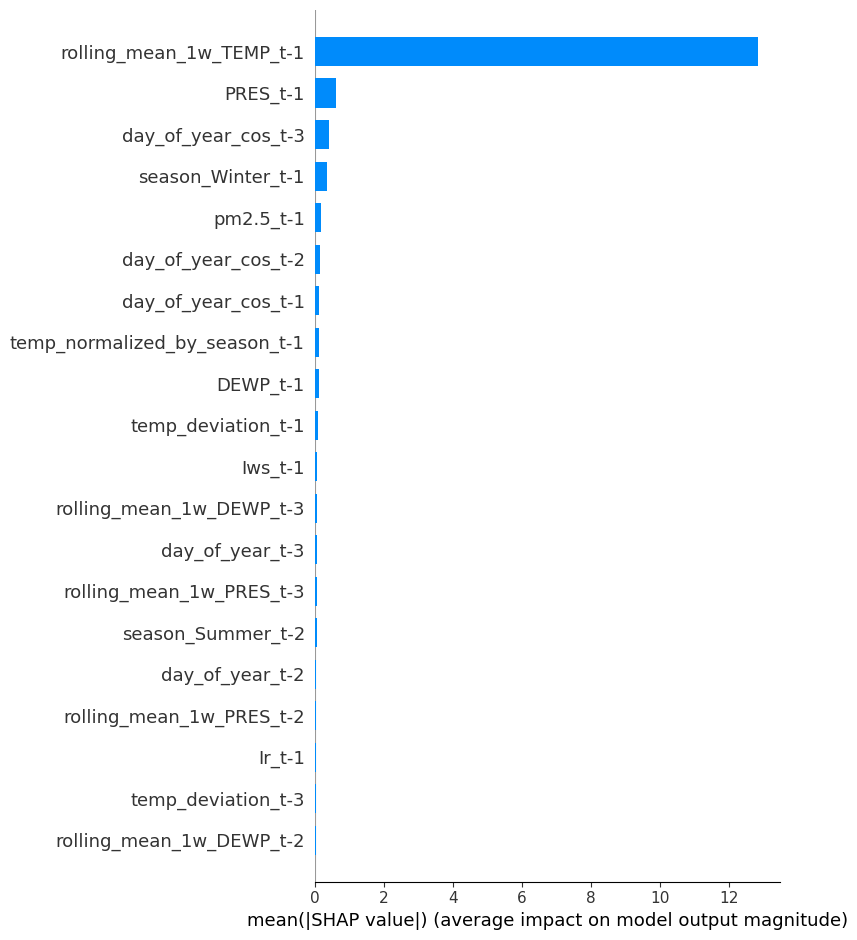

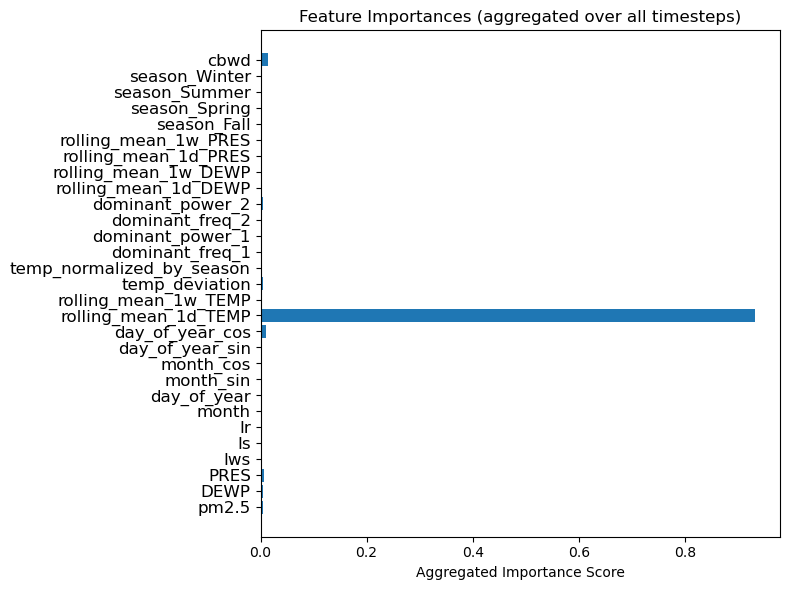

Feature names: ['pm2.5_t-3', 'DEWP_t-3', 'PRES_t-3', 'Iws_t-3', 'Is_t-3', 'Ir_t-3', 'month_t-3', 'day_of_year_t-3', 'month_sin_t-3', 'month_cos_t-3', 'day_of_year_sin_t-3', 'day_of_year_cos_t-3', 'rolling_mean_1w_TEMP_t-3', 'temp_deviation_t-3', 'temp_normalized_by_season_t-3', 'dominant_freq_1_t-3', 'dominant_power_1_t-3', 'dominant_freq_2_t-3', 'dominant_power_2_t-3', 'rolling_mean_1w_DEWP_t-3', 'rolling_mean_1w_PRES_t-3', 'cbwd_NE_t-3', 'cbwd_NW_t-3', 'cbwd_SE_t-3', 'cbwd_cv_t-3', 'season_Fall_t-3', 'season_Spring_t-3', 'season_Summer_t-3', 'season_Winter_t-3', 'pm2.5_t-2', 'DEWP_t-2', 'PRES_t-2', 'Iws_t-2', 'Is_t-2', 'Ir_t-2', 'month_t-2', 'day_of_year_t-2', 'month_sin_t-2', 'month_cos_t-2', 'day_of_year_sin_t-2', 'day_of_year_cos_t-2', 'rolling_mean_1w_TEMP_t-2', 'temp_deviation_t-2', 'temp_normalized_by_season_t-2', 'dominant_freq_1_t-2', 'dominant_power_1_t-2', 'dominant_freq_2_t-2', 'dominant_power_2_t-2', 'rolling_mean_1w_DEWP_t-2', 'rolling_mean_1w_PRES_t-2', 'cbwd_NE_t-2', '

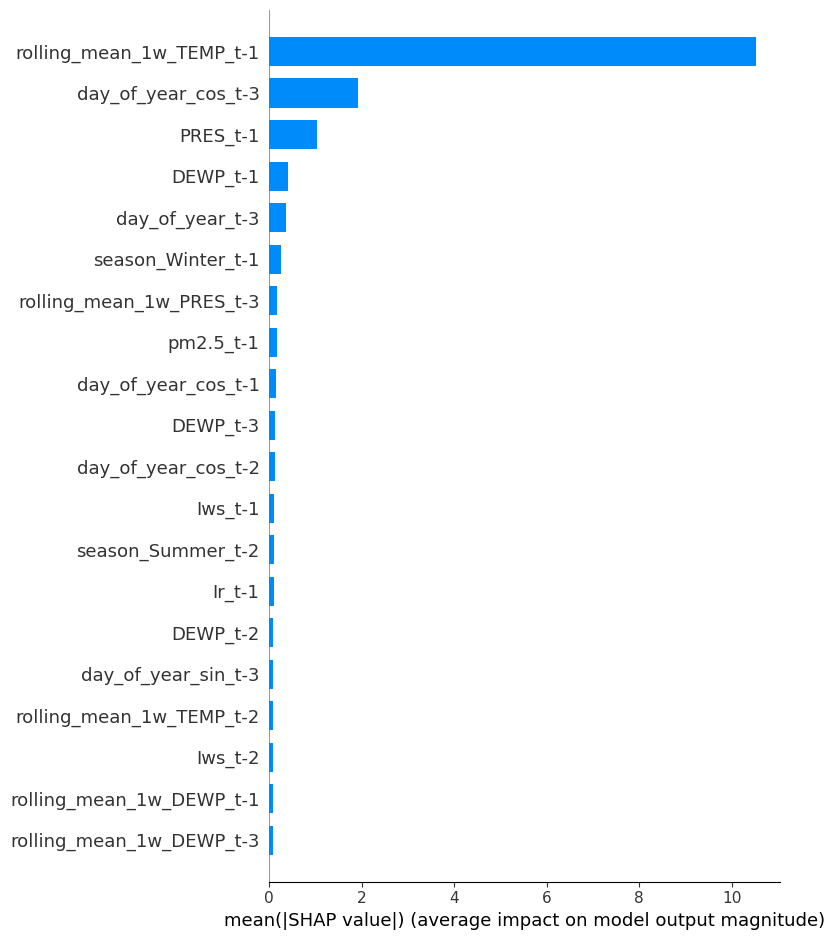

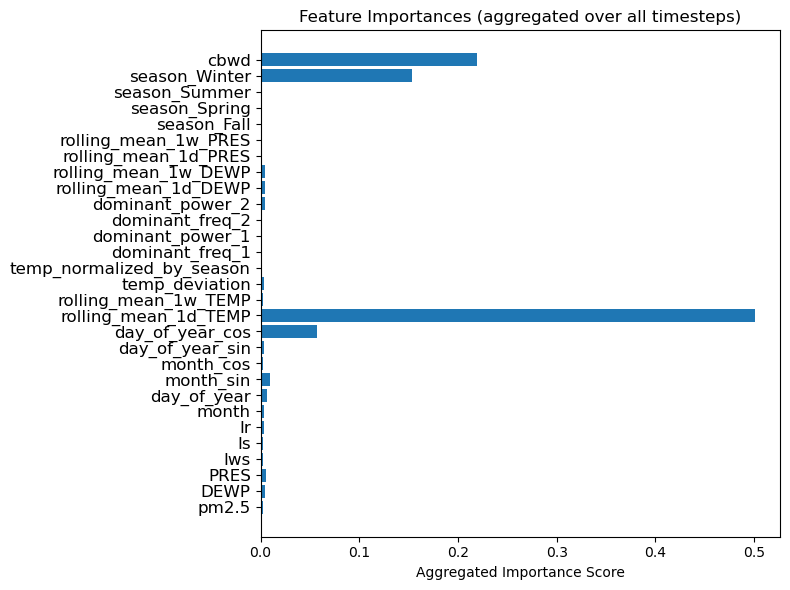

RandomForest on last 30 days → RMSE: 1.967,  MAE: 1.569 , MSE: 3.871
XGBoost on last 30 days → RMSE: 1.993,  MAE: 1.568 , MSE: 3.971


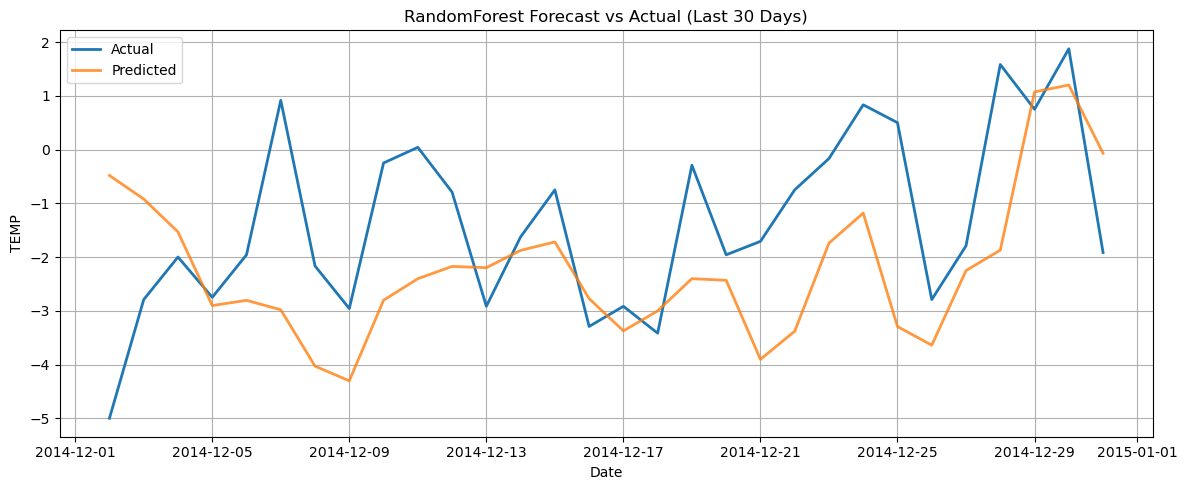

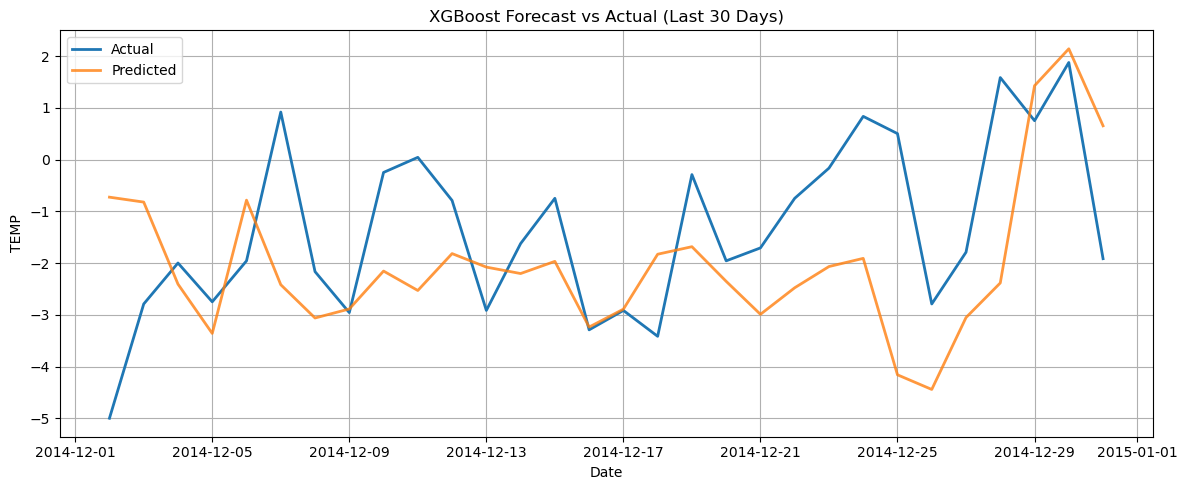

In [209]:
seq_length = 3
target_col = 'TEMP'

X_seq, y_seq = create_forecasting_sequences(df_new, seq_length, target_col)
all_dates = df_new.index[seq_length:]

X_flat = X_seq.reshape(X_seq.shape[0], -1)
scaler = StandardScaler()
X_flat_scaled = scaler.fit_transform(X_flat)

test_size = 30
train_end = len(X_flat_scaled) - test_size

X_train, X_test = X_flat_scaled[:train_end], X_flat_scaled[train_end:]
y_train, y_test = y_seq[:train_end], y_seq[train_end:]
dates_test = all_dates[-test_size:]  


models = {
    "RandomForest": RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    "XGBoost":      XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42, n_jobs=-1, objective="reg:squarederror"),
    # "SVR":          SVR(kernel='rbf', C=1.0, epsilon=0.1)
}

results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae  = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    
    original_features = df_new.columns.drop(target_col)  
    feature_names = []
    for lag in range(seq_length, 0, -1):
        feature_names += [f"{col}_t-{lag}" for col in original_features]

    feature_names += [f"{target_col}_t-{lag}" for lag in range(seq_length, 0, -1)]

    print("Feature names:", feature_names)

    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test, check_additivity=False)

    shap.summary_plot(
        shap_values,      
        X_test,
        plot_type="bar",
        feature_names=feature_names,
        title = f"SHAP Summary Plot for {name} Model",
    )


    results[name] = {
        "RMSE":    rmse,
        "MAE":     mae,
        "MSE":     mse,
        "y_true":  y_test,
        "y_pred":  y_pred
    }
    
    importances = model.feature_importances_
    target_col = 'TEMP'

    feature_cols = [c for c in df_rf.columns if c != target_col]
    n_feats = len(feature_cols)
    timesteps = X_seq.shape[1]

    agg_importances = np.zeros(n_feats)
    for t in range(timesteps):
        start = t * n_feats
        end   = start + n_feats
        agg_importances += importances[start:end]


    plt.figure(figsize=(8, 6))
    y_pos = np.arange(len(feature_cols))
    plt.barh(y_pos, agg_importances, align='center')
    plt.yticks(y_pos, feature_cols, fontsize=12)
    plt.xlabel("Aggregated Importance Score")
    plt.title("Feature Importances (aggregated over all timesteps)")
    plt.tight_layout()
    plt.show()


for name, m in results.items():
    print(f"{name} on last {test_size} days → RMSE: {m['RMSE']:.3f},  MAE: {m['MAE']:.3f} , MSE: {m['MSE']:.3f}")

for name, m in results.items():
    plt.figure(figsize=(12, 5))
    plt.plot(dates_test, m['y_true'], label="Actual", linewidth=2)
    plt.plot(dates_test, m['y_pred'], label="Predicted", linewidth=2, alpha=0.8)
    plt.title(f"{name} Forecast vs Actual (Last {test_size} Days)")
    plt.xlabel("Date")
    plt.ylabel(target_col)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()